In [1]:
import datetime

import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostRegressor, EFeaturesSelectionAlgorithm
from catboost import Pool
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ts_package.feature_engineering.utils import make_time_based_features
from ts_package.tuning import objective
from ts_package.validation.feature_selection import get_catboost_feature_importances, select_features_wrapped_catboost
from ts_package.validation.validation import get_time_series_cv_score

/Users/m1crozavr/anaconda3/envs/time-series/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings


warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [3]:
# time-based features
# optuna with target metric
# feature selection methods

In [4]:
df = pd.read_csv('../data/finalFeatures.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Income,Outcome,Balance,Налог на прибыль (при уплате только ежеквартальных авансовых платежей),Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца),Праздники РФ,Inflation Rate MoM: actual,Inflation Rate MoM: forecastCorrection,Balance of Trade: actual,Balance of Trade: forecastCorrection,...,Balance lag 20,Balance lag 21,Balance lag 22,Balance lag 23,Balance lag 24,Balance lag 25,Balance lag 26,Balance lag 27,Balance lag 28,Balance lag 29
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,1.340000,1.490000,-0.155904,0.0,0.600000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1.068610,1.194182,-0.125572,0.0,0.666667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,0.944429,0.936663,0.007767,0.0,0.733333,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,1.670000,0.875379,0.800391,0.0,0.800000,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,0.955924,0.975645,-0.019721,0.0,0.866667,0.0,0.6,-0.1,11.45,-0.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df = make_time_based_features(df)

In [6]:
OOT_THRESHOLD = datetime.datetime(2021, 1, 1)
COLUMNS_TO_DROP = ['Balance', 'Outcome', 'Income']
X_train, y_train, X_test, y_test = df[df.index < OOT_THRESHOLD].drop(COLUMNS_TO_DROP, axis=1), df.loc[df.index < OOT_THRESHOLD, 'Balance'],\
    df[df.index >= OOT_THRESHOLD].drop(COLUMNS_TO_DROP, axis=1), df.loc[df.index >= OOT_THRESHOLD, 'Balance']
print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 1453, Test size: 90


# Feature selection

**Feature selection techniques can be divided in groups:**

- Wrapper methods - eliminating of features based on weights/coefficients of a trained model.
- Filter methods - eliminating of features based on some statistics and correlations between features and target variable (without training a model).
- Embedded methods - eliminating of features during a model training, for example, by applying L1 regularization or calculation tree's criterion gain.


**Отбираться будет порядка 15-21 главных признаков**
(По итогу на 21-м признаке лучше качество)

## Wrapper methods
В качестве 3-х оберточных методов в работе используются реализации библиотеки CatBoost:

1. Based on Prediction Values Change. EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
3. Based on Loss Function Change. EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
4. Based on Shap Values. EFeaturesSelectionAlgorithm.RecursiveByShapValues

**Исследуют нелинейность**

In [7]:
N_IMPORTANT_FEATURES = 21
# fs - feature selection
# Для фильтрации признаков можно сформировать обычную случайную out of fold валидационную выборку
X_train_fs, X_val_fs, y_train_fs, y_val_fs = train_test_split(X_train, y_train, train_size=0.8, random_state=777)
feature_names = X_train.columns.tolist()
cat_features = ['weekday', 'Праздники РФ', 'quarter']
train_pool = Pool(X_train_fs, y_train_fs, feature_names=feature_names, cat_features=cat_features)
val_pool = Pool(X_val_fs, y_val_fs, feature_names=feature_names, cat_features=cat_features)

In [8]:
shap_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(shap_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
{'selected_features': [1, 5, 15, 20, 22, 23, 28, 31, 34, 39, 40, 41, 47, 48, 50, 51, 53, 54, 60, 61, 63], 'eliminated_features_names': ['is_weekend', 'Праздники РФ', 'quarter', 'Inflation Rate MoM: actual', 'Unemployment Rate: actual', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 23', 'Balance lag 10', 'Налог на прибыль (при уплате только ежеквартальных авансовых платежей)', 'Markit Manufacturing PMI: actual', 'Retail Sales YoY: forecastCorrection', 'Real Wage Growth YoY: actual', 'Balance lag 12', 'Balance lag 9', 'Balance lag 11', 'Business Confidence: actual', 'PPI MoM: forecastCorrection', 'BZ=F', 'Balance lag 24', 'Business Confidence: forecastCorrection', 'Balance of Trade: forecastCorrection', 'Real Wage Growth YoY: forecastCorrection', 'Dollar', 'Key_rate', 'Balance lag 5', 'Retail Sales YoY: actual', 'Industrial Production YoY: actual', 'Foreign Exchange Reserves: forecastC

In [9]:
lfc_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(lfc_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
{'selected_features': [0, 1, 7, 18, 23, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 40, 53, 61, 63, 64, 65], 'eliminated_features_names': ['Balance lag 8', 'Balance lag 26', 'Markit Services PMI: forecastCorrection', 'Balance lag 14', 'Balance lag 22', 'Balance lag 27', 'Balance lag 25', 'PPI MoM: actual', 'Balance lag 13', 'Balance lag 6', 'Balance of Trade: actual', 'Balance lag 21', 'Balance lag 15', 'Balance lag 29', 'Corporate Profits: forecastCorrection', 'Balance lag 24', 'Real Wage Growth YoY: forecastCorrection', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 17', 'Balance lag 19', 'PPI MoM: forecastCorrection', 'Balance lag 18', 'Corporate Profits: actual', 'Balance lag 10', 'Balance lag 16', 'Balance of Trade: forecastCorrection', 'Balance lag 12', 'Retail Sales YoY: actual', 'Balance lag 5', 'Markit Manufacturing PMI: actual', 'Foreign Exchange Reserves: forecastCorrection', 'Indu

In [10]:
pvc_summary = select_features_wrapped_catboost(
    feature_names,
    EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange,
    train_pool, val_pool,
    steps=15,
    n_features=N_IMPORTANT_FEATURES
)
print(pvc_summary)

Algorithm for feature selection: EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange
{'selected_features': [1, 5, 15, 20, 22, 23, 28, 31, 34, 39, 40, 41, 47, 48, 50, 51, 53, 54, 60, 61, 63], 'eliminated_features_names': ['is_weekend', 'Праздники РФ', 'quarter', 'Inflation Rate MoM: actual', 'Unemployment Rate: actual', 'Inflation Rate MoM: forecastCorrection', 'Balance lag 23', 'Balance lag 10', 'Налог на прибыль (при уплате только ежеквартальных авансовых платежей)', 'Markit Manufacturing PMI: actual', 'Retail Sales YoY: forecastCorrection', 'Real Wage Growth YoY: actual', 'Balance lag 12', 'Balance lag 9', 'Balance lag 11', 'Business Confidence: actual', 'PPI MoM: forecastCorrection', 'BZ=F', 'Balance lag 24', 'Business Confidence: forecastCorrection', 'Balance of Trade: forecastCorrection', 'Real Wage Growth YoY: forecastCorrection', 'Dollar', 'Key_rate', 'Balance lag 5', 'Retail Sales YoY: actual', 'Industrial Production YoY: actual', 'Foreign Exchange Reserves: forecastC

## Embedded method
В качестве встроенного метода в работе используется важность признаков при построении алгоритма случайного леса.

The impurity-based feature importances.
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. Squared error for RandomForestRegressor.

**Исследует нелинейность**

In [12]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=777)
rf_model.fit(X_train_fs[~X_train_fs.isna().any(axis=1)], y_train_fs[~X_train_fs.isna().any(axis=1)])
feature_importance_sorted_indexes = np.argsort(rf_model.feature_importances_)[-N_IMPORTANT_FEATURES:]
rf_important_features = dict(
    zip(
        rf_model.feature_names_in_[feature_importance_sorted_indexes],
        rf_model.feature_importances_[feature_importance_sorted_indexes]
    )
)
rf_important_features

{'Balance lag 22': 0.01632464852045337,
 'Balance lag 29': 0.017691214917885407,
 'Balance lag 25': 0.0182296401806807,
 'Balance lag 10': 0.018451857359232594,
 'Balance lag 18': 0.018878742632061362,
 'Balance lag 15': 0.01899171236639701,
 'Balance lag 27': 0.019123509004386866,
 'Balance lag 16': 0.01944279216646284,
 'Balance lag 9': 0.019479556743735433,
 'Balance lag 20': 0.020834128566369087,
 'Balance lag 4': 0.02356867522237286,
 'Balance lag 26': 0.023855578457039433,
 'Balance lag 6': 0.024599923839461458,
 'Balance lag 19': 0.027979691789012898,
 'Balance lag 14': 0.03027907238650555,
 'Balance lag 8': 0.03717103713419924,
 'weekday': 0.0401110216410937,
 'Balance lag 21': 0.04133489551177642,
 'Balance lag 28': 0.047411680511556996,
 'Balance lag 1': 0.05434388357700047,
 'Balance lag 7': 0.0878235419847851}

## Filter method
В качестве фильтрационного метода в работе используется Correlation-based Feature Selection.

Его преимущество в простоте и интерпретируемости, недостатки в ограничении линейности, так как используется корреляция Пирсона.

**Не исследует нелинейность**

In [13]:
feature_target_correlation = X_train[~X_train.isna().any(axis=1)].corrwith(y_train[~X_train.isna().any(axis=1)])
feature_target_correlation

Налог на прибыль (при уплате только ежеквартальных авансовых платежей)   -0.112321
Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)               0.055371
Праздники РФ                                                              0.000935
Inflation Rate MoM: actual                                               -0.002128
Inflation Rate MoM: forecastCorrection                                   -0.023608
                                                                            ...   
Balance lag 28                                                            0.182461
Balance lag 29                                                            0.068180
weekday                                                                   0.188907
quarter                                                                  -0.004390
is_weekend                                                                0.077867
Length: 66, dtype: float64

In [14]:
cfs_important_features = np.abs(feature_target_correlation).sort_values(ascending=False)[:N_IMPORTANT_FEATURES]
cfs_important_features

Balance lag 7                                                             0.246458
weekday                                                                   0.188907
Balance lag 28                                                            0.182461
Foreign Exchange Reserves: actual                                         0.165658
IMOEX.ME                                                                  0.160397
Gold                                                                      0.151527
Key_rate                                                                  0.150408
Balance lag 14                                                            0.147700
Balance lag 21                                                            0.144671
Dollar                                                                    0.122576
USDRUB=X                                                                  0.118958
Balance lag 1                                                             0.116534
Нало

## Stability
Стабильность альтернативных методов отбора признаков будет проверена при помощи упорядоченной во времени кросс-валидации, подсчета среднего значения и стандартного отклонения целевой бизнес метрики и MAE на тренировочном и валидационном фолде.

In [15]:
shap_features = shap_summary['selected_features_names']
X_train_shap = X_train[shap_features]
shap_cv_result = get_time_series_cv_score(X_train_shap, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153595	total: 1.81ms	remaining: 1.8s
500:	learn: 0.0433082	total: 242ms	remaining: 241ms
999:	learn: 0.0093059	total: 474ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2306059	total: 1.26ms	remaining: 1.26s
500:	learn: 0.0603189	total: 364ms	remaining: 363ms
999:	learn: 0.0209816	total: 728ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2598573	total: 1.05ms	remaining: 1.05s
500:	learn: 0.0786027	total: 380ms	remaining: 378ms
999:	learn: 0.0296456	total: 766ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629822	total: 696us	remaining: 696ms
500:	learn: 0.0970865	total: 388ms	remaining: 387ms
999:	learn: 0.0408342	total: 786ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2826025	total: 790us	remaining: 790ms
500:	learn: 0.1119486	total: 401ms	remaining: 399ms
999:	learn: 0.0520378	total: 803ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2839401	total: 767us	remaining: 767ms
500:	lear

In [16]:
shap_cv_result

{'bm_mean': -0.0936528745811558,
 'bm_std': 0.5272502579045983,
 'mae_mean': 0.17320943677133593,
 'mae_std': 0.030559885800084237}

In [17]:
lfc_features = lfc_summary['selected_features_names']
X_train_lfc = X_train[lfc_features]
lfc_cv_result = get_time_series_cv_score(X_train_lfc, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2151209	total: 1.57ms	remaining: 1.57s
500:	learn: 0.0465168	total: 240ms	remaining: 239ms
999:	learn: 0.0092835	total: 465ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2317590	total: 695us	remaining: 695ms
500:	learn: 0.0794302	total: 318ms	remaining: 317ms
999:	learn: 0.0271743	total: 642ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2597895	total: 606us	remaining: 606ms
500:	learn: 0.0949573	total: 349ms	remaining: 347ms
999:	learn: 0.0384848	total: 694ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2631152	total: 688us	remaining: 688ms
500:	learn: 0.1194160	total: 356ms	remaining: 355ms
999:	learn: 0.0596220	total: 712ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2823576	total: 725us	remaining: 725ms
500:	learn: 0.1337175	total: 367ms	remaining: 366ms
999:	learn: 0.0742764	total: 739ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2834385	total: 813us	remaining: 813ms
500:	learn

In [18]:
lfc_cv_result

{'bm_mean': 0.02330100955097547,
 'bm_std': 0.5144565935383005,
 'mae_mean': 0.191931789337524,
 'mae_std': 0.028184625449289492}

In [19]:
pvc_features = pvc_summary['selected_features_names']
X_train_pvc = X_train[pvc_features]
pvc_cv_result = get_time_series_cv_score(X_train_pvc, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153595	total: 1.12ms	remaining: 1.12s
500:	learn: 0.0433082	total: 247ms	remaining: 246ms
999:	learn: 0.0093059	total: 492ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2306059	total: 664us	remaining: 664ms
500:	learn: 0.0603189	total: 358ms	remaining: 357ms
999:	learn: 0.0209816	total: 718ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2598573	total: 680us	remaining: 680ms
500:	learn: 0.0786027	total: 377ms	remaining: 376ms
999:	learn: 0.0296456	total: 754ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629822	total: 703us	remaining: 703ms
500:	learn: 0.0970865	total: 464ms	remaining: 462ms
999:	learn: 0.0408342	total: 854ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2826025	total: 797us	remaining: 796ms
500:	learn: 0.1119486	total: 398ms	remaining: 397ms
999:	learn: 0.0520378	total: 800ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2839401	total: 804us	remaining: 804ms
500:	learn

In [20]:
pvc_cv_result

{'bm_mean': -0.0936528745811558,
 'bm_std': 0.5272502579045983,
 'mae_mean': 0.17320943677133593,
 'mae_std': 0.030559885800084237}

In [21]:
rf_features = rf_important_features.keys()
X_train_rf = X_train[rf_features]
rf_cv_result = get_time_series_cv_score(X_train_rf, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2153013	total: 1.33ms	remaining: 1.33s
500:	learn: 0.0421070	total: 276ms	remaining: 275ms
999:	learn: 0.0098989	total: 554ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2313275	total: 898us	remaining: 898ms
500:	learn: 0.0657918	total: 404ms	remaining: 402ms
999:	learn: 0.0212323	total: 805ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2596213	total: 845us	remaining: 845ms
500:	learn: 0.0813060	total: 424ms	remaining: 422ms
999:	learn: 0.0345584	total: 858ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2632344	total: 854us	remaining: 854ms
500:	learn: 0.0977212	total: 436ms	remaining: 434ms
999:	learn: 0.0455284	total: 872ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2823254	total: 896us	remaining: 896ms
500:	learn: 0.1209281	total: 449ms	remaining: 447ms
999:	learn: 0.0610015	total: 896ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2845894	total: 297us	remaining: 297ms
500:	learn

In [22]:
rf_cv_result

{'bm_mean': -0.18648658867695467,
 'bm_std': 0.37506574512109403,
 'mae_mean': 0.17214285856879213,
 'mae_std': 0.03315293251585714}

In [23]:
cfs_features = cfs_important_features.index.tolist()
X_train_cfs = X_train[cfs_features]
cfs_cv_result = get_time_series_cv_score(X_train_cfs, y_train, {'random_state': 777}, CatBoostRegressor)

Learning rate set to 0.031388
0:	learn: 0.2155245	total: 768us	remaining: 767ms
500:	learn: 0.0415307	total: 242ms	remaining: 241ms
999:	learn: 0.0088216	total: 478ms	remaining: 0us
Learning rate set to 0.034946
0:	learn: 0.2315590	total: 708us	remaining: 708ms
500:	learn: 0.0711674	total: 343ms	remaining: 341ms
999:	learn: 0.0239550	total: 688ms	remaining: 0us
Learning rate set to 0.037231
0:	learn: 0.2595348	total: 729us	remaining: 728ms
500:	learn: 0.0957706	total: 368ms	remaining: 367ms
999:	learn: 0.0393431	total: 740ms	remaining: 0us
Learning rate set to 0.038948
0:	learn: 0.2629346	total: 653us	remaining: 652ms
500:	learn: 0.1139837	total: 382ms	remaining: 380ms
999:	learn: 0.0537427	total: 765ms	remaining: 0us
Learning rate set to 0.040337
0:	learn: 0.2824908	total: 794us	remaining: 793ms
500:	learn: 0.1341263	total: 389ms	remaining: 387ms
999:	learn: 0.0763459	total: 780ms	remaining: 0us
Learning rate set to 0.04151
0:	learn: 0.2837535	total: 729us	remaining: 729ms
500:	learn:

In [24]:
cfs_cv_result

{'bm_mean': -0.0025555441902532943,
 'bm_std': 0.6416747084611824,
 'mae_mean': 0.19101038142554785,
 'mae_std': 0.03222945198531938}

In [25]:
# Итоговая таблица стабильности методов
stability_result_df = pd.DataFrame(
    [shap_cv_result, lfc_cv_result, pvc_cv_result, rf_cv_result, cfs_cv_result],
    index=['Shap', 'Loss function change', 'Prediction values change', 'Random forest feature importance', 'Correlation-based'],
)
stability_result_df.columns = ['Business metric mean', 'Business metric std', 'MAE mean', 'MAE std']
stability_result_df

,Business metric mean,Business metric std,MAE mean,MAE std
Shap,-0.093653,0.527250,0.173209,0.030560
Loss function change,0.023301,0.514457,0.191932,0.028185
Prediction values change,-0.093653,0.527250,0.173209,0.030560
Random forest feature importance,-0.186487,0.375066,0.172143,0.033153
Correlation-based,-0.002556,0.641675,0.191010,0.032229


С точки зрения стабильности и показанных результатов итоговый метод выбора признаков - **CatBoost recursive loss function change based feature selection algorithm**.

In [26]:
lfc_features

['Налог на прибыль (при уплате только ежеквартальных авансовых платежей)',
 'Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)',
 'Foreign Exchange Reserves: actual',
 'Retail Sales YoY: forecastCorrection',
 'Markit Services PMI: actual',
 'Business Confidence: forecastCorrection',
 'BZ=F',
 'IMOEX.ME',
 'Key_rate',
 'Euro',
 'Dollar',
 'Gold',
 'Balance lag 1',
 'Balance lag 2',
 'Balance lag 3',
 'Balance lag 7',
 'Balance lag 20',
 'Balance lag 28',
 'weekday',
 'quarter',
 'is_weekend']

# Model tuning targeting business metric
Модель автоматически подбирает гиперпараметры, оптимизируя целевую бизнес метрику.

In [27]:
# DataFrame с отобранными признаками
X_train_opt, X_test_opt = X_train[lfc_features], X_test[lfc_features]
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_opt, y_train), n_trials=100, timeout=1200, show_progress_bar=True)

[I 2024-04-14 21:31:29,980] A new study created in memory with name: no-name-40b1ff58-007d-4044-8edb-64b4094bebad
  0%|                                                                                             | 0/100 [00:00<?, ?it/s]

0:	learn: 0.1092063	total: 1.05ms	remaining: 1.15s
500:	learn: 0.0590705	total: 124ms	remaining: 146ms
1000:	learn: 0.0420675	total: 248ms	remaining: 22.5ms
1091:	learn: 0.0403997	total: 269ms	remaining: 0us
0:	learn: 0.1257365	total: 431us	remaining: 471ms
500:	learn: 0.0838232	total: 160ms	remaining: 188ms
1000:	learn: 0.0647041	total: 333ms	remaining: 30.3ms
1091:	learn: 0.0624027	total: 363ms	remaining: 0us
0:	learn: 0.1336590	total: 346us	remaining: 378ms
500:	learn: 0.0975678	total: 177ms	remaining: 209ms
1000:	learn: 0.0796962	total: 361ms	remaining: 32.8ms
1091:	learn: 0.0775005	total: 396ms	remaining: 0us
0:	learn: 0.1400621	total: 506us	remaining: 553ms
500:	learn: 0.1115027	total: 193ms	remaining: 227ms
1000:	learn: 0.0943564	total: 383ms	remaining: 34.8ms
1091:	learn: 0.0921351	total: 418ms	remaining: 0us
0:	learn: 0.1555991	total: 949us	remaining: 1.03s
500:	learn: 0.1226663	total: 199ms	remaining: 235ms
1000:	learn: 0.1059225	total: 408ms	remaining: 37.1ms
1091:	learn: 0.

Best trial: 0. Best value: -0.109867:   1%|▎                           | 1/100 [00:03<05:05,  3.09s/it, 3.09/1200 seconds]

1000:	learn: 0.1131818	total: 425ms	remaining: 38.7ms
1091:	learn: 0.1112666	total: 465ms	remaining: 0us
[I 2024-04-14 21:31:33,078] Trial 0 finished with value: -0.10986732143841896 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 1092, 'min_data_in_leaf': 1, 'random_strength': 6.255479573950397}. Best is trial 0 with value: -0.10986732143841896.
0:	learn: 0.1084999	total: 2.19ms	remaining: 588ms
269:	learn: 0.0200532	total: 244ms	remaining: 0us
0:	learn: 0.1250246	total: 2.45ms	remaining: 658ms
269:	learn: 0.0397996	total: 378ms	remaining: 0us
0:	learn: 0.1331837	total: 1.76ms	remaining: 474ms
269:	learn: 0.0512577	total: 383ms	remaining: 0us
0:	learn: 0.1394883	total: 1.51ms	remaining: 408ms
269:	learn: 0.0667928	total: 394ms	remaining: 0us
0:	learn: 0.1546528	total: 1.48ms	remaining: 398ms
269:	learn: 0.0852337	total: 398ms	remaining: 0us
0:	learn: 0.1583513	total: 1.69ms	remaining: 454ms
269:	learn: 0.0873532	total: 407ms	remaining: 0us
0:	learn: 0.1568656	total

Best trial: 0. Best value: -0.109867:   2%|▌                           | 2/100 [00:05<04:44,  2.90s/it, 5.86/1200 seconds]

269:	learn: 0.0865630	total: 423ms	remaining: 0us
[I 2024-04-14 21:31:35,852] Trial 1 finished with value: -0.2489401043854321 and parameters: {'loss_function': 'MAPE', 'depth': 8, 'iterations': 270, 'min_data_in_leaf': 8, 'random_strength': 0.7341927732603726}. Best is trial 0 with value: -0.10986732143841896.
0:	learn: 0.1113245	total: 1.05ms	remaining: 1.01s
500:	learn: 0.0075337	total: 465ms	remaining: 430ms
963:	learn: 0.0018286	total: 905ms	remaining: 0us
0:	learn: 0.1272473	total: 1.68ms	remaining: 1.62s
500:	learn: 0.0184023	total: 714ms	remaining: 660ms
963:	learn: 0.0074686	total: 1.38s	remaining: 0us
0:	learn: 0.1377681	total: 1.56ms	remaining: 1.51s
500:	learn: 0.0266746	total: 741ms	remaining: 684ms
963:	learn: 0.0116233	total: 1.43s	remaining: 0us
0:	learn: 0.1432328	total: 1.75ms	remaining: 1.68s
500:	learn: 0.0405427	total: 872ms	remaining: 806ms
963:	learn: 0.0190699	total: 1.58s	remaining: 0us
0:	learn: 0.1590626	total: 1.62ms	remaining: 1.56s
500:	learn: 0.0507372	to

Best trial: 0. Best value: -0.109867:   3%|▊                          | 3/100 [00:16<10:08,  6.27s/it, 16.14/1200 seconds]

963:	learn: 0.0391480	total: 1.53s	remaining: 0us
[I 2024-04-14 21:31:46,128] Trial 2 finished with value: -0.2113929179064819 and parameters: {'loss_function': 'MAE', 'depth': 8, 'iterations': 964, 'min_data_in_leaf': 64, 'random_strength': 1.681618999412876}. Best is trial 0 with value: -0.10986732143841896.
0:	learn: 0.1118313	total: 736us	remaining: 300ms
407:	learn: 0.0322355	total: 189ms	remaining: 0us
0:	learn: 0.1271600	total: 629us	remaining: 256ms
407:	learn: 0.0524628	total: 269ms	remaining: 0us
0:	learn: 0.1380050	total: 647us	remaining: 263ms
407:	learn: 0.0671743	total: 282ms	remaining: 0us
0:	learn: 0.1438244	total: 807us	remaining: 328ms
407:	learn: 0.0819953	total: 296ms	remaining: 0us
0:	learn: 0.1596339	total: 807us	remaining: 329ms
407:	learn: 0.0954508	total: 298ms	remaining: 0us
0:	learn: 0.1629684	total: 846us	remaining: 344ms
407:	learn: 0.1028601	total: 305ms	remaining: 0us
0:	learn: 0.1616675	total: 844us	remaining: 344ms


Best trial: 3. Best value: -0.0950611:   4%|█                         | 4/100 [00:18<07:23,  4.62s/it, 18.24/1200 seconds]

407:	learn: 0.1055357	total: 314ms	remaining: 0us
[I 2024-04-14 21:31:48,231] Trial 3 finished with value: -0.09506108566350212 and parameters: {'loss_function': 'MAE', 'depth': 6, 'iterations': 408, 'min_data_in_leaf': 2, 'random_strength': 0.7651932325194966}. Best is trial 3 with value: -0.09506108566350212.
0:	learn: 0.1123765	total: 1ms	remaining: 1.26s
500:	learn: 0.0596890	total: 106ms	remaining: 160ms
1000:	learn: 0.0442351	total: 229ms	remaining: 59.3ms
1259:	learn: 0.0394237	total: 292ms	remaining: 0us
0:	learn: 0.1276140	total: 328us	remaining: 413ms
500:	learn: 0.0828990	total: 171ms	remaining: 260ms
1000:	learn: 0.0642548	total: 336ms	remaining: 87.1ms
1259:	learn: 0.0593927	total: 429ms	remaining: 0us
0:	learn: 0.1383424	total: 362us	remaining: 456ms
500:	learn: 0.0995584	total: 185ms	remaining: 281ms
1000:	learn: 0.0813224	total: 373ms	remaining: 96.5ms
1259:	learn: 0.0753943	total: 466ms	remaining: 0us
0:	learn: 0.1441146	total: 450us	remaining: 567ms
500:	learn: 0.1124

Best trial: 4. Best value: -0.0295892:   5%|█▎                        | 5/100 [00:21<06:42,  4.24s/it, 21.79/1200 seconds]

1000:	learn: 0.1148619	total: 441ms	remaining: 114ms
1259:	learn: 0.1104380	total: 555ms	remaining: 0us
[I 2024-04-14 21:31:51,788] Trial 4 finished with value: -0.02958924500882117 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 1260, 'min_data_in_leaf': 56, 'random_strength': 3.203652255735787}. Best is trial 4 with value: -0.02958924500882117.
Learning rate set to 0.026526
0:	learn: 0.2156223	total: 737us	remaining: 906ms
500:	learn: 0.0767415	total: 216ms	remaining: 314ms
1000:	learn: 0.0192975	total: 435ms	remaining: 99.5ms
1229:	learn: 0.0110932	total: 532ms	remaining: 0us
Learning rate set to 0.029533
0:	learn: 0.2318123	total: 799us	remaining: 983ms
500:	learn: 0.1075483	total: 325ms	remaining: 473ms
1000:	learn: 0.0469822	total: 646ms	remaining: 148ms
1229:	learn: 0.0309036	total: 793ms	remaining: 0us
Learning rate set to 0.031464
0:	learn: 0.2604873	total: 647us	remaining: 796ms
500:	learn: 0.1326387	total: 334ms	remaining: 486ms
1000:	learn: 0.0631287	tota

Best trial: 4. Best value: -0.0295892:   6%|█▌                        | 6/100 [00:27<07:37,  4.87s/it, 27.89/1200 seconds]

1000:	learn: 0.1158644	total: 752ms	remaining: 172ms
1229:	learn: 0.0964894	total: 926ms	remaining: 0us
[I 2024-04-14 21:31:57,885] Trial 5 finished with value: -0.08174940679020902 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 1230, 'min_data_in_leaf': 86, 'random_strength': 9.344583608824657}. Best is trial 4 with value: -0.02958924500882117.
Learning rate set to 0.042044
0:	learn: 0.2158942	total: 609us	remaining: 425ms
500:	learn: 0.0482258	total: 166ms	remaining: 65.1ms
697:	learn: 0.0244652	total: 229ms	remaining: 0us
Learning rate set to 0.04681
0:	learn: 0.2317221	total: 551us	remaining: 384ms
500:	learn: 0.0837320	total: 226ms	remaining: 88.8ms
697:	learn: 0.0554201	total: 317ms	remaining: 0us
Learning rate set to 0.049871
0:	learn: 0.2603951	total: 457us	remaining: 319ms
500:	learn: 0.1029755	total: 243ms	remaining: 95.7ms
697:	learn: 0.0728571	total: 340ms	remaining: 0us
Learning rate set to 0.052172
0:	learn: 0.2634132	total: 478us	remaining: 334ms
500

Best trial: 6. Best value: 0.0880821:   7%|█▉                         | 7/100 [00:30<06:22,  4.12s/it, 30.45/1200 seconds]

500:	learn: 0.1610687	total: 280ms	remaining: 110ms
697:	learn: 0.1332734	total: 392ms	remaining: 0us
[I 2024-04-14 21:32:00,445] Trial 6 finished with value: 0.08808213019337055 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 698, 'min_data_in_leaf': 26, 'random_strength': 7.88881846280275}. Best is trial 6 with value: 0.08808213019337055.
0:	learn: 0.1112784	total: 977us	remaining: 1.33s
500:	learn: 0.0069538	total: 481ms	remaining: 829ms
1000:	learn: 0.0014158	total: 961ms	remaining: 350ms
1364:	learn: 0.0004140	total: 1.31s	remaining: 0us
0:	learn: 0.1264925	total: 1.72ms	remaining: 2.35s
500:	learn: 0.0151585	total: 733ms	remaining: 1.26s
1000:	learn: 0.0066344	total: 1.45s	remaining: 526ms
1364:	learn: 0.0045035	total: 1.97s	remaining: 0us
0:	learn: 0.1374413	total: 1.59ms	remaining: 2.17s
500:	learn: 0.0228927	total: 752ms	remaining: 1.3s
1000:	learn: 0.0092576	total: 1.5s	remaining: 547ms
1364:	learn: 0.0061632	total: 2.06s	remaining: 0us
0:	learn: 0.1432281

Best trial: 6. Best value: 0.0880821:   8%|██▏                        | 8/100 [00:44<11:21,  7.41s/it, 44.91/1200 seconds]

1364:	learn: 0.0280711	total: 2.16s	remaining: 0us
[I 2024-04-14 21:32:14,903] Trial 7 finished with value: -0.15360834067063944 and parameters: {'loss_function': 'MAE', 'depth': 8, 'iterations': 1365, 'min_data_in_leaf': 50, 'random_strength': 0.09994210187727393}. Best is trial 6 with value: 0.08808213019337055.
0:	learn: 0.1115638	total: 778us	remaining: 665ms
500:	learn: 0.0433781	total: 177ms	remaining: 125ms
854:	learn: 0.0308110	total: 289ms	remaining: 0us
0:	learn: 0.1274772	total: 479us	remaining: 410ms
500:	learn: 0.0622290	total: 234ms	remaining: 166ms
854:	learn: 0.0497584	total: 403ms	remaining: 0us
0:	learn: 0.1379977	total: 581us	remaining: 496ms
500:	learn: 0.0790330	total: 254ms	remaining: 180ms
854:	learn: 0.0648322	total: 432ms	remaining: 0us
0:	learn: 0.1438610	total: 618us	remaining: 528ms
500:	learn: 0.0936973	total: 273ms	remaining: 193ms
854:	learn: 0.0797681	total: 467ms	remaining: 0us
0:	learn: 0.1594817	total: 655us	remaining: 560ms
500:	learn: 0.1055992	tota

Best trial: 6. Best value: 0.0880821:   9%|██▍                        | 9/100 [00:48<09:17,  6.12s/it, 48.20/1200 seconds]

854:	learn: 0.1014136	total: 500ms	remaining: 0us
[I 2024-04-14 21:32:18,196] Trial 8 finished with value: 0.03933445463930035 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 855, 'min_data_in_leaf': 91, 'random_strength': 0.3557336219350382}. Best is trial 6 with value: 0.08808213019337055.
0:	learn: 0.1123633	total: 723us	remaining: 346ms
478:	learn: 0.0472623	total: 159ms	remaining: 0us
0:	learn: 0.1275718	total: 500us	remaining: 239ms
478:	learn: 0.0693683	total: 227ms	remaining: 0us
0:	learn: 0.1383391	total: 509us	remaining: 244ms
478:	learn: 0.0872335	total: 245ms	remaining: 0us
0:	learn: 0.1442164	total: 520us	remaining: 249ms
478:	learn: 0.1009393	total: 250ms	remaining: 0us
0:	learn: 0.1600889	total: 697us	remaining: 333ms
478:	learn: 0.1168157	total: 277ms	remaining: 0us
0:	learn: 0.1633955	total: 578us	remaining: 276ms
478:	learn: 0.1200653	total: 266ms	remaining: 0us
0:	learn: 0.1618510	total: 749us	remaining: 358ms


Best trial: 6. Best value: 0.0880821:  10%|██▌                       | 10/100 [00:50<07:12,  4.80s/it, 50.05/1200 seconds]

478:	learn: 0.1229341	total: 278ms	remaining: 0us
[I 2024-04-14 21:32:20,043] Trial 9 finished with value: -0.0718988623240092 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 479, 'min_data_in_leaf': 9, 'random_strength': 7.472966520288461}. Best is trial 6 with value: 0.08808213019337055.
Learning rate set to 0.04433
0:	learn: 0.2150308	total: 658us	remaining: 430ms
500:	learn: 0.0194236	total: 312ms	remaining: 95.4ms
653:	learn: 0.0088010	total: 412ms	remaining: 0us
Learning rate set to 0.049355
0:	learn: 0.2316003	total: 886us	remaining: 579ms
500:	learn: 0.0386832	total: 465ms	remaining: 142ms
653:	learn: 0.0234998	total: 611ms	remaining: 0us
Learning rate set to 0.052583
0:	learn: 0.2602215	total: 1.07ms	remaining: 697ms
500:	learn: 0.0588423	total: 496ms	remaining: 151ms
653:	learn: 0.0380838	total: 649ms	remaining: 0us
Learning rate set to 0.055008
0:	learn: 0.2636537	total: 1.02ms	remaining: 665ms
500:	learn: 0.0765338	total: 497ms	remaining: 152ms
653:	learn

Best trial: 6. Best value: 0.0880821:  11%|██▊                       | 11/100 [00:54<07:01,  4.74s/it, 54.65/1200 seconds]

500:	learn: 0.1093465	total: 518ms	remaining: 158ms
653:	learn: 0.0847110	total: 668ms	remaining: 0us
[I 2024-04-14 21:32:24,642] Trial 10 finished with value: -0.10898552730378837 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 654, 'min_data_in_leaf': 31, 'random_strength': 9.855195707569969}. Best is trial 6 with value: 0.08808213019337055.
Learning rate set to 0.039445
0:	learn: 0.2154946	total: 869us	remaining: 656ms
500:	learn: 0.0506730	total: 166ms	remaining: 84.3ms
754:	learn: 0.0217427	total: 244ms	remaining: 0us
Learning rate set to 0.043916
0:	learn: 0.2315431	total: 468us	remaining: 353ms
500:	learn: 0.0856733	total: 224ms	remaining: 114ms
754:	learn: 0.0519488	total: 340ms	remaining: 0us
Learning rate set to 0.046788
0:	learn: 0.2602297	total: 714us	remaining: 539ms
500:	learn: 0.1084574	total: 245ms	remaining: 124ms
754:	learn: 0.0712403	total: 372ms	remaining: 0us
Learning rate set to 0.048946
0:	learn: 0.2634476	total: 484us	remaining: 365ms
500:	le

Best trial: 11. Best value: 0.0908788:  12%|███                      | 12/100 [00:57<06:04,  4.15s/it, 57.44/1200 seconds]

500:	learn: 0.1636365	total: 277ms	remaining: 140ms
754:	learn: 0.1307060	total: 422ms	remaining: 0us
[I 2024-04-14 21:32:27,429] Trial 11 finished with value: 0.09087879559254378 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 755, 'min_data_in_leaf': 98, 'random_strength': 4.18834775367046}. Best is trial 11 with value: 0.09087879559254378.
Learning rate set to 0.043626
0:	learn: 0.2154268	total: 626us	remaining: 417ms
500:	learn: 0.0420292	total: 163ms	remaining: 54.1ms
666:	learn: 0.0241837	total: 223ms	remaining: 0us
Learning rate set to 0.048572
0:	learn: 0.2314876	total: 472us	remaining: 315ms
500:	learn: 0.0797450	total: 229ms	remaining: 75.9ms
666:	learn: 0.0567072	total: 305ms	remaining: 0us
Learning rate set to 0.051748
0:	learn: 0.2601730	total: 1.34ms	remaining: 895ms
500:	learn: 0.1007306	total: 240ms	remaining: 79.4ms
666:	learn: 0.0733865	total: 321ms	remaining: 0us
Learning rate set to 0.054135
0:	learn: 0.2633922	total: 1.73ms	remaining: 1.15s
500:

Best trial: 12. Best value: 0.114577:  13%|███▍                      | 13/100 [00:59<05:16,  3.63s/it, 59.89/1200 seconds]

500:	learn: 0.1556051	total: 275ms	remaining: 91.3ms
666:	learn: 0.1341783	total: 369ms	remaining: 0us
[I 2024-04-14 21:32:29,887] Trial 12 finished with value: 0.11457695444458471 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 667, 'min_data_in_leaf': 30, 'random_strength': 4.452449711834864}. Best is trial 12 with value: 0.11457695444458471.
Learning rate set to 0.042998
0:	learn: 0.2154370	total: 1.03ms	remaining: 698ms
500:	learn: 0.0422332	total: 160ms	remaining: 57ms
678:	learn: 0.0236086	total: 216ms	remaining: 0us
Learning rate set to 0.047873
0:	learn: 0.2314960	total: 419us	remaining: 284ms
500:	learn: 0.0785505	total: 233ms	remaining: 82.6ms
678:	learn: 0.0539054	total: 313ms	remaining: 0us
Learning rate set to 0.051003
0:	learn: 0.2601815	total: 1.2ms	remaining: 813ms
500:	learn: 0.1015125	total: 243ms	remaining: 86.3ms
678:	learn: 0.0717111	total: 329ms	remaining: 0us
Learning rate set to 0.053356
0:	learn: 0.2634005	total: 661us	remaining: 448ms
500:	

Best trial: 13. Best value: 0.125506:  14%|███▋                      | 14/100 [01:02<04:43,  3.29s/it, 62.39/1200 seconds]

500:	learn: 0.1575378	total: 278ms	remaining: 98.7ms
678:	learn: 0.1326139	total: 376ms	remaining: 0us
[I 2024-04-14 21:32:32,386] Trial 13 finished with value: 0.12550595955628965 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 679, 'min_data_in_leaf': 76, 'random_strength': 4.190627730193965}. Best is trial 13 with value: 0.12550595955628965.
Learning rate set to 0.050659
0:	learn: 0.2154247	total: 1.04ms	remaining: 576ms
500:	learn: 0.0574563	total: 126ms	remaining: 13.6ms
554:	learn: 0.0501947	total: 138ms	remaining: 0us
Learning rate set to 0.056401
0:	learn: 0.2317394	total: 1.03ms	remaining: 572ms
500:	learn: 0.0932700	total: 164ms	remaining: 17.7ms
554:	learn: 0.0842684	total: 180ms	remaining: 0us
Learning rate set to 0.060089
0:	learn: 0.2602109	total: 1.04ms	remaining: 576ms
500:	learn: 0.1143894	total: 166ms	remaining: 17.9ms
554:	learn: 0.1047626	total: 187ms	remaining: 0us
Learning rate set to 0.062861
0:	learn: 0.2633298	total: 442us	remaining: 245ms
5

Best trial: 13. Best value: 0.125506:  15%|███▉                      | 15/100 [01:03<03:55,  2.77s/it, 63.95/1200 seconds]

500:	learn: 0.1680045	total: 209ms	remaining: 22.5ms
554:	learn: 0.1601149	total: 237ms	remaining: 0us
[I 2024-04-14 21:32:33,941] Trial 14 finished with value: 0.09016138754470805 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 555, 'min_data_in_leaf': 74, 'random_strength': 5.234282150994176}. Best is trial 13 with value: 0.12550595955628965.
Learning rate set to 0.032121
0:	learn: 0.2155788	total: 553us	remaining: 537ms
500:	learn: 0.0460519	total: 218ms	remaining: 205ms
971:	learn: 0.0111498	total: 427ms	remaining: 0us
Learning rate set to 0.035762
0:	learn: 0.2313686	total: 1.42ms	remaining: 1.38s
500:	learn: 0.0794196	total: 331ms	remaining: 311ms
971:	learn: 0.0315672	total: 651ms	remaining: 0us
Learning rate set to 0.038101
0:	learn: 0.2601647	total: 670us	remaining: 651ms
500:	learn: 0.1042906	total: 337ms	remaining: 316ms
971:	learn: 0.0466777	total: 660ms	remaining: 0us
Learning rate set to 0.039858
0:	learn: 0.2634470	total: 779us	remaining: 757ms
500:	l

Best trial: 13. Best value: 0.125506:  16%|████▏                     | 16/100 [01:08<04:45,  3.40s/it, 68.80/1200 seconds]

971:	learn: 0.0983829	total: 729ms	remaining: 0us
[I 2024-04-14 21:32:38,798] Trial 15 finished with value: -0.04176037377233101 and parameters: {'loss_function': 'RMSE', 'depth': 6, 'iterations': 972, 'min_data_in_leaf': 40, 'random_strength': 2.9188223074517112}. Best is trial 13 with value: 0.12550595955628965.
Learning rate set to 0.115216
0:	learn: 0.2133851	total: 673us	remaining: 135ms
201:	learn: 0.0141280	total: 126ms	remaining: 0us
Learning rate set to 0.128276
0:	learn: 0.2298506	total: 950us	remaining: 191ms
201:	learn: 0.0381021	total: 187ms	remaining: 0us
Learning rate set to 0.136665
0:	learn: 0.2588909	total: 1.01ms	remaining: 203ms
201:	learn: 0.0525195	total: 194ms	remaining: 0us
Learning rate set to 0.142968
0:	learn: 0.2622550	total: 962us	remaining: 193ms
201:	learn: 0.0675996	total: 199ms	remaining: 0us
Learning rate set to 0.148067
0:	learn: 0.2809859	total: 1.15ms	remaining: 231ms
201:	learn: 0.0863179	total: 203ms	remaining: 0us
Learning rate set to 0.152372
0:

Best trial: 13. Best value: 0.125506:  17%|████▍                     | 17/100 [01:10<03:52,  2.80s/it, 70.23/1200 seconds]

201:	learn: 0.1007249	total: 210ms	remaining: 0us
[I 2024-04-14 21:32:40,224] Trial 16 finished with value: -0.17570092025568762 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 202, 'min_data_in_leaf': 72, 'random_strength': 5.024329360340357}. Best is trial 13 with value: 0.12550595955628965.
Learning rate set to 0.036098
0:	learn: 0.2155490	total: 1.08ms	remaining: 907ms
500:	learn: 0.0571974	total: 158ms	remaining: 108ms
841:	learn: 0.0225110	total: 272ms	remaining: 0us
Learning rate set to 0.04019
0:	learn: 0.2315876	total: 588us	remaining: 495ms
500:	learn: 0.0919764	total: 226ms	remaining: 154ms
841:	learn: 0.0506101	total: 383ms	remaining: 0us
Learning rate set to 0.042818
0:	learn: 0.2602753	total: 434us	remaining: 365ms
500:	learn: 0.1178166	total: 247ms	remaining: 168ms
841:	learn: 0.0700320	total: 411ms	remaining: 0us
Learning rate set to 0.044793
0:	learn: 0.2634922	total: 542us	remaining: 456ms
500:	learn: 0.1354355	total: 258ms	remaining: 176ms
841:	le

Best trial: 17. Best value: 0.194959:  18%|████▋                     | 18/100 [01:13<03:57,  2.89s/it, 73.33/1200 seconds]

841:	learn: 0.1287810	total: 472ms	remaining: 0us
[I 2024-04-14 21:32:43,322] Trial 17 finished with value: 0.1949591903152708 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 842, 'min_data_in_leaf': 19, 'random_strength': 3.5488568432194576}. Best is trial 17 with value: 0.1949591903152708.
0:	learn: 0.1089110	total: 587us	remaining: 880ms
500:	learn: 0.0153054	total: 323ms	remaining: 643ms
1000:	learn: 0.0058043	total: 659ms	remaining: 328ms
1498:	learn: 0.0030592	total: 979ms	remaining: 0us
0:	learn: 0.1257495	total: 863us	remaining: 1.29s
500:	learn: 0.0313720	total: 474ms	remaining: 945ms
1000:	learn: 0.0145331	total: 956ms	remaining: 475ms
1498:	learn: 0.0093409	total: 1.42s	remaining: 0us
0:	learn: 0.1335907	total: 1.08ms	remaining: 1.62s
500:	learn: 0.0469944	total: 488ms	remaining: 972ms
1000:	learn: 0.0254669	total: 986ms	remaining: 490ms
1498:	learn: 0.0170449	total: 1.48s	remaining: 0us
0:	learn: 0.1399853	total: 973us	remaining: 1.46s
500:	learn: 0.0624

Best trial: 17. Best value: 0.194959:  19%|████▉                     | 19/100 [01:23<07:01,  5.20s/it, 83.91/1200 seconds]

1498:	learn: 0.0463676	total: 1.6s	remaining: 0us
[I 2024-04-14 21:32:53,905] Trial 18 finished with value: -0.09693774463321302 and parameters: {'loss_function': 'MAPE', 'depth': 7, 'iterations': 1499, 'min_data_in_leaf': 17, 'random_strength': 2.7564383206060104}. Best is trial 17 with value: 0.1949591903152708.
Learning rate set to 0.035316
0:	learn: 0.2159792	total: 448us	remaining: 388ms
500:	learn: 0.0832234	total: 112ms	remaining: 81.1ms
864:	learn: 0.0417372	total: 202ms	remaining: 0us
Learning rate set to 0.039319
0:	learn: 0.2318397	total: 944us	remaining: 816ms
500:	learn: 0.1195338	total: 166ms	remaining: 121ms
864:	learn: 0.0779881	total: 284ms	remaining: 0us
Learning rate set to 0.04189
0:	learn: 0.2605092	total: 336us	remaining: 291ms
500:	learn: 0.1486421	total: 172ms	remaining: 125ms
864:	learn: 0.1009434	total: 300ms	remaining: 0us
Learning rate set to 0.043822
0:	learn: 0.2635236	total: 1.04ms	remaining: 899ms
500:	learn: 0.1698490	total: 183ms	remaining: 133ms
864:	

Best trial: 17. Best value: 0.194959:  20%|█████▏                    | 20/100 [01:26<05:47,  4.35s/it, 86.27/1200 seconds]

500:	learn: 0.1930594	total: 210ms	remaining: 153ms
864:	learn: 0.1554006	total: 364ms	remaining: 0us
[I 2024-04-14 21:32:56,265] Trial 19 finished with value: 0.16952590382657054 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 865, 'min_data_in_leaf': 46, 'random_strength': 6.290466189614132}. Best is trial 17 with value: 0.1949591903152708.
Learning rate set to 0.035382
0:	learn: 0.2159789	total: 536us	remaining: 463ms
500:	learn: 0.0843793	total: 120ms	remaining: 86.9ms
862:	learn: 0.0416885	total: 185ms	remaining: 0us
Learning rate set to 0.039393
0:	learn: 0.2318393	total: 1.04ms	remaining: 899ms
500:	learn: 0.1190143	total: 162ms	remaining: 117ms
862:	learn: 0.0771062	total: 282ms	remaining: 0us
Learning rate set to 0.041969
0:	learn: 0.2605087	total: 512us	remaining: 442ms
500:	learn: 0.1467847	total: 173ms	remaining: 125ms
862:	learn: 0.1013892	total: 302ms	remaining: 0us
Learning rate set to 0.043905
0:	learn: 0.2635228	total: 329us	remaining: 284ms
500:	le

Best trial: 17. Best value: 0.194959:  21%|█████▍                    | 21/100 [01:28<04:55,  3.74s/it, 88.60/1200 seconds]

500:	learn: 0.1921283	total: 208ms	remaining: 150ms
862:	learn: 0.1573259	total: 357ms	remaining: 0us
[I 2024-04-14 21:32:58,592] Trial 20 finished with value: 0.18421959302527763 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 863, 'min_data_in_leaf': 40, 'random_strength': 6.303155677144534}. Best is trial 17 with value: 0.1949591903152708.
Learning rate set to 0.03502
0:	learn: 0.2159806	total: 319us	remaining: 279ms
500:	learn: 0.0828688	total: 122ms	remaining: 90.8ms
873:	learn: 0.0426177	total: 219ms	remaining: 0us
Learning rate set to 0.03899
0:	learn: 0.2318416	total: 363us	remaining: 317ms
500:	learn: 0.1203606	total: 164ms	remaining: 122ms
873:	learn: 0.0775082	total: 287ms	remaining: 0us
Learning rate set to 0.041539
0:	learn: 0.2605114	total: 425us	remaining: 372ms
500:	learn: 0.1496924	total: 178ms	remaining: 132ms
873:	learn: 0.1010577	total: 305ms	remaining: 0us
Learning rate set to 0.043455
0:	learn: 0.2635274	total: 354us	remaining: 309ms
500:	learn

Best trial: 21. Best value: 0.24467:  22%|█████▉                     | 22/100 [01:31<04:21,  3.35s/it, 91.03/1200 seconds]

500:	learn: 0.1914859	total: 215ms	remaining: 160ms
873:	learn: 0.1552035	total: 373ms	remaining: 0us
[I 2024-04-14 21:33:01,027] Trial 21 finished with value: 0.2446700285974948 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 874, 'min_data_in_leaf': 46, 'random_strength': 6.5159107919328605}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.030546
0:	learn: 0.2160006	total: 454us	remaining: 470ms
500:	learn: 0.1002755	total: 124ms	remaining: 132ms
1000:	learn: 0.0428666	total: 247ms	remaining: 8.13ms
1033:	learn: 0.0405660	total: 254ms	remaining: 0us
Learning rate set to 0.034009
0:	learn: 0.2318711	total: 961us	remaining: 994ms
500:	learn: 0.1304556	total: 168ms	remaining: 178ms
1000:	learn: 0.0773694	total: 337ms	remaining: 11.1ms
1033:	learn: 0.0746118	total: 348ms	remaining: 0us
Learning rate set to 0.036233
0:	learn: 0.2605447	total: 382us	remaining: 395ms
500:	learn: 0.1588090	total: 183ms	remaining: 195ms
1000:	learn: 0.0986569	total:

Best trial: 21. Best value: 0.24467:  23%|██████▏                    | 23/100 [01:33<04:06,  3.20s/it, 93.88/1200 seconds]

1000:	learn: 0.1583086	total: 420ms	remaining: 13.9ms
1033:	learn: 0.1557098	total: 434ms	remaining: 0us
[I 2024-04-14 21:33:03,870] Trial 22 finished with value: 0.16688428418086382 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1034, 'min_data_in_leaf': 38, 'random_strength': 6.50243071646548}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.036666
0:	learn: 0.2159732	total: 653us	remaining: 539ms
500:	learn: 0.0806909	total: 117ms	remaining: 76ms
825:	learn: 0.0419931	total: 183ms	remaining: 0us
Learning rate set to 0.040822
0:	learn: 0.2318308	total: 429us	remaining: 355ms
500:	learn: 0.1188285	total: 167ms	remaining: 109ms
825:	learn: 0.0779648	total: 277ms	remaining: 0us
Learning rate set to 0.043491
0:	learn: 0.2604991	total: 393us	remaining: 325ms
500:	learn: 0.1459037	total: 165ms	remaining: 107ms
825:	learn: 0.1029978	total: 280ms	remaining: 0us
Learning rate set to 0.045497
0:	learn: 0.2635064	total: 382us	remaining: 316ms
500:	le

Best trial: 21. Best value: 0.24467:  24%|██████▍                    | 24/100 [01:36<03:41,  2.91s/it, 96.13/1200 seconds]

500:	learn: 0.1914150	total: 208ms	remaining: 135ms
825:	learn: 0.1575725	total: 341ms	remaining: 0us
[I 2024-04-14 21:33:06,123] Trial 23 finished with value: 0.12859925862778873 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 826, 'min_data_in_leaf': 20, 'random_strength': 7.204914890627159}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.034288
0:	learn: 0.2160044	total: 290us	remaining: 261ms
500:	learn: 0.0864818	total: 118ms	remaining: 93.3ms
896:	learn: 0.0411077	total: 213ms	remaining: 0us
Learning rate set to 0.038175
0:	learn: 0.2318634	total: 411us	remaining: 369ms
500:	learn: 0.1235406	total: 164ms	remaining: 129ms
896:	learn: 0.0786563	total: 297ms	remaining: 0us
Learning rate set to 0.040671
0:	learn: 0.2605168	total: 462us	remaining: 415ms
500:	learn: 0.1483694	total: 176ms	remaining: 139ms
896:	learn: 0.0959849	total: 316ms	remaining: 0us
Learning rate set to 0.042547
0:	learn: 0.2637995	total: 1.04ms	remaining: 933ms
500:	le

Best trial: 21. Best value: 0.24467:  25%|██████▊                    | 25/100 [01:38<03:28,  2.77s/it, 98.58/1200 seconds]

500:	learn: 0.1965726	total: 203ms	remaining: 160ms
896:	learn: 0.1584208	total: 364ms	remaining: 0us
[I 2024-04-14 21:33:08,571] Trial 24 finished with value: 0.0881786612893584 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 897, 'min_data_in_leaf': 58, 'random_strength': 8.493473701962333}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1091432	total: 1.2ms	remaining: 1.41s
500:	learn: 0.0448234	total: 168ms	remaining: 225ms
1000:	learn: 0.0278843	total: 333ms	remaining: 56.6ms
1170:	learn: 0.0254242	total: 389ms	remaining: 0us
0:	learn: 0.1257078	total: 572us	remaining: 670ms
500:	learn: 0.0666647	total: 236ms	remaining: 316ms
1000:	learn: 0.0459672	total: 472ms	remaining: 80.1ms
1170:	learn: 0.0414997	total: 549ms	remaining: 0us
0:	learn: 0.1336424	total: 520us	remaining: 609ms
500:	learn: 0.0819303	total: 246ms	remaining: 328ms
1000:	learn: 0.0598181	total: 500ms	remaining: 85ms
1170:	learn: 0.0552937	total: 593ms	remaining: 0us
0:	learn: 0.14005

Best trial: 21. Best value: 0.24467:  26%|██████▊                   | 26/100 [01:43<04:02,  3.27s/it, 103.01/1200 seconds]

1000:	learn: 0.0984150	total: 575ms	remaining: 97.6ms
1170:	learn: 0.0941982	total: 673ms	remaining: 0us
[I 2024-04-14 21:33:13,007] Trial 25 finished with value: -0.06839113888930137 and parameters: {'loss_function': 'MAPE', 'depth': 5, 'iterations': 1171, 'min_data_in_leaf': 39, 'random_strength': 5.877794938149455}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.030028
0:	learn: 0.2157144	total: 258us	remaining: 273ms
500:	learn: 0.0984340	total: 117ms	remaining: 130ms
1000:	learn: 0.0434312	total: 208ms	remaining: 11.4ms
1055:	learn: 0.0396451	total: 218ms	remaining: 0us
Learning rate set to 0.033432
0:	learn: 0.2318745	total: 331us	remaining: 350ms
500:	learn: 0.1316074	total: 160ms	remaining: 177ms
1000:	learn: 0.0768851	total: 325ms	remaining: 17.8ms
1055:	learn: 0.0729345	total: 342ms	remaining: 0us
Learning rate set to 0.035618
0:	learn: 0.2605486	total: 374us	remaining: 395ms
500:	learn: 0.1601895	total: 176ms	remaining: 195ms
1000:	learn: 0.1018345	t

Best trial: 21. Best value: 0.24467:  27%|███████                   | 27/100 [01:45<03:49,  3.14s/it, 105.85/1200 seconds]

1000:	learn: 0.1568827	total: 423ms	remaining: 23.2ms
1055:	learn: 0.1534606	total: 445ms	remaining: 0us
[I 2024-04-14 21:33:15,845] Trial 26 finished with value: 0.221373710669275 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1056, 'min_data_in_leaf': 20, 'random_strength': 5.520319373717747}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.029112
0:	learn: 0.2156626	total: 1.06ms	remaining: 1.16s
500:	learn: 0.0747055	total: 160ms	remaining: 190ms
1000:	learn: 0.0229256	total: 326ms	remaining: 31.3ms
1096:	learn: 0.0189410	total: 357ms	remaining: 0us
Learning rate set to 0.032412
0:	learn: 0.2316809	total: 424us	remaining: 465ms
500:	learn: 0.1080681	total: 236ms	remaining: 281ms
1000:	learn: 0.0517180	total: 472ms	remaining: 45.3ms
1096:	learn: 0.0440895	total: 518ms	remaining: 0us
Learning rate set to 0.034532
0:	learn: 0.2603710	total: 439us	remaining: 482ms
500:	learn: 0.1387370	total: 250ms	remaining: 297ms
1000:	learn: 0.0741680	tot

Best trial: 21. Best value: 0.24467:  28%|███████▎                  | 28/100 [01:49<04:05,  3.40s/it, 109.86/1200 seconds]

1000:	learn: 0.1340700	total: 553ms	remaining: 53ms
1096:	learn: 0.1262132	total: 608ms	remaining: 0us
[I 2024-04-14 21:33:19,857] Trial 27 finished with value: 0.07094759997512547 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1097, 'min_data_in_leaf': 14, 'random_strength': 3.7305036552433495}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.031934
0:	learn: 0.2157548	total: 276us	remaining: 270ms
500:	learn: 0.0829571	total: 125ms	remaining: 119ms
978:	learn: 0.0357332	total: 244ms	remaining: 0us
Learning rate set to 0.035554
0:	learn: 0.2315091	total: 445us	remaining: 436ms
500:	learn: 0.1192123	total: 171ms	remaining: 163ms
978:	learn: 0.0699381	total: 324ms	remaining: 0us
Learning rate set to 0.037879
0:	learn: 0.2602719	total: 382us	remaining: 374ms
500:	learn: 0.1452556	total: 172ms	remaining: 164ms
978:	learn: 0.0903650	total: 335ms	remaining: 0us
Learning rate set to 0.039626
0:	learn: 0.2632848	total: 954us	remaining: 934ms
500:	l

Best trial: 21. Best value: 0.24467:  29%|███████▌                  | 29/100 [01:52<03:45,  3.18s/it, 112.53/1200 seconds]

978:	learn: 0.1520777	total: 410ms	remaining: 0us
[I 2024-04-14 21:33:22,526] Trial 28 finished with value: 0.21743714387859306 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 979, 'min_data_in_leaf': 23, 'random_strength': 1.956683084564029}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1092063	total: 991us	remaining: 1.11s
500:	learn: 0.0598013	total: 130ms	remaining: 160ms
1000:	learn: 0.0423176	total: 259ms	remaining: 30ms
1116:	learn: 0.0402358	total: 297ms	remaining: 0us
0:	learn: 0.1259163	total: 875us	remaining: 977ms
500:	learn: 0.0825152	total: 178ms	remaining: 218ms
1000:	learn: 0.0629323	total: 348ms	remaining: 40.3ms
1116:	learn: 0.0604784	total: 386ms	remaining: 0us
0:	learn: 0.1336823	total: 440us	remaining: 492ms
500:	learn: 0.0965182	total: 177ms	remaining: 217ms
1000:	learn: 0.0778335	total: 359ms	remaining: 41.6ms
1116:	learn: 0.0753866	total: 400ms	remaining: 0us
0:	learn: 0.1400605	total: 504us	remaining: 564ms
500:	learn: 0.1176

Best trial: 21. Best value: 0.24467:  30%|███████▊                  | 30/100 [01:55<03:43,  3.20s/it, 115.76/1200 seconds]

1000:	learn: 0.1213034	total: 446ms	remaining: 51.7ms
1116:	learn: 0.1183839	total: 497ms	remaining: 0us
[I 2024-04-14 21:33:25,756] Trial 29 finished with value: -0.044535783588529936 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 1117, 'min_data_in_leaf': 26, 'random_strength': 2.256119492793246}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.031185
0:	learn: 0.2156981	total: 1.01ms	remaining: 1.01s
500:	learn: 0.0950079	total: 99ms	remaining: 100ms
1000:	learn: 0.0396800	total: 214ms	remaining: 1.5ms
1007:	learn: 0.0392823	total: 216ms	remaining: 0us
Learning rate set to 0.03472
0:	learn: 0.2318669	total: 470us	remaining: 474ms
500:	learn: 0.1272510	total: 161ms	remaining: 163ms
1000:	learn: 0.0739635	total: 335ms	remaining: 2.34ms
1007:	learn: 0.0732717	total: 338ms	remaining: 0us
Learning rate set to 0.036991
0:	learn: 0.2605400	total: 1.03ms	remaining: 1.03s
500:	learn: 0.1570119	total: 182ms	remaining: 184ms
1000:	learn: 0.0978710	t

Best trial: 21. Best value: 0.24467:  31%|████████                  | 31/100 [01:58<03:31,  3.06s/it, 118.51/1200 seconds]

1000:	learn: 0.1560749	total: 424ms	remaining: 2.96ms
1007:	learn: 0.1554620	total: 427ms	remaining: 0us
[I 2024-04-14 21:33:28,501] Trial 30 finished with value: 0.22071800201817685 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1008, 'min_data_in_leaf': 1, 'random_strength': 5.746569458840589}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.030936
0:	learn: 0.2157016	total: 419us	remaining: 427ms
500:	learn: 0.0954438	total: 122ms	remaining: 126ms
1000:	learn: 0.0412788	total: 246ms	remaining: 4.18ms
1017:	learn: 0.0400654	total: 250ms	remaining: 0us
Learning rate set to 0.034443
0:	learn: 0.2318685	total: 1.03ms	remaining: 1.05s
500:	learn: 0.1313089	total: 162ms	remaining: 167ms
1000:	learn: 0.0759192	total: 322ms	remaining: 5.46ms
1017:	learn: 0.0745328	total: 329ms	remaining: 0us
Learning rate set to 0.036695
0:	learn: 0.2605418	total: 466us	remaining: 474ms
500:	learn: 0.1560713	total: 177ms	remaining: 183ms
1000:	learn: 0.0975745	to

Best trial: 21. Best value: 0.24467:  32%|████████▎                 | 32/100 [02:01<03:24,  3.01s/it, 121.39/1200 seconds]

1000:	learn: 0.1547677	total: 508ms	remaining: 8.63ms
1017:	learn: 0.1535067	total: 516ms	remaining: 0us
[I 2024-04-14 21:33:31,384] Trial 31 finished with value: 0.1874736270966582 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1018, 'min_data_in_leaf': 6, 'random_strength': 5.63008518567533}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.031855
0:	learn: 0.2159947	total: 269us	remaining: 265ms
500:	learn: 0.0966584	total: 113ms	remaining: 108ms
981:	learn: 0.0424650	total: 233ms	remaining: 0us
Learning rate set to 0.035466
0:	learn: 0.2318625	total: 330us	remaining: 324ms
500:	learn: 0.1284705	total: 164ms	remaining: 157ms
981:	learn: 0.0755639	total: 329ms	remaining: 0us
Learning rate set to 0.037785
0:	learn: 0.2605350	total: 1.02ms	remaining: 999ms
500:	learn: 0.1583977	total: 178ms	remaining: 171ms
981:	learn: 0.0975376	total: 350ms	remaining: 0us
Learning rate set to 0.039528
0:	learn: 0.2635678	total: 348us	remaining: 342ms
500:	le

Best trial: 21. Best value: 0.24467:  33%|████████▌                 | 33/100 [02:04<03:15,  2.92s/it, 124.10/1200 seconds]

981:	learn: 0.1559920	total: 409ms	remaining: 0us
[I 2024-04-14 21:33:34,093] Trial 32 finished with value: 0.13718751776427257 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 982, 'min_data_in_leaf': 11, 'random_strength': 6.939647372600861}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1092063	total: 428us	remaining: 559ms
500:	learn: 0.0595223	total: 122ms	remaining: 196ms
1000:	learn: 0.0433692	total: 249ms	remaining: 75.5ms
1304:	learn: 0.0375562	total: 326ms	remaining: 0us
0:	learn: 0.1257365	total: 947us	remaining: 1.24s
500:	learn: 0.0836683	total: 166ms	remaining: 266ms
1000:	learn: 0.0639879	total: 339ms	remaining: 103ms
1304:	learn: 0.0574773	total: 447ms	remaining: 0us
0:	learn: 0.1336590	total: 541us	remaining: 706ms
500:	learn: 0.0982380	total: 179ms	remaining: 287ms
1000:	learn: 0.0793012	total: 352ms	remaining: 107ms
1304:	learn: 0.0726538	total: 455ms	remaining: 0us
0:	learn: 0.1400621	total: 459us	remaining: 599ms
500:	learn: 0.1104

Best trial: 21. Best value: 0.24467:  34%|████████▊                 | 34/100 [02:07<03:26,  3.13s/it, 127.73/1200 seconds]

1000:	learn: 0.1141842	total: 435ms	remaining: 132ms
1304:	learn: 0.1087711	total: 565ms	remaining: 0us
[I 2024-04-14 21:33:37,721] Trial 33 finished with value: -0.006535595515023014 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 1305, 'min_data_in_leaf': 2, 'random_strength': 5.52450096050302}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.027607
0:	learn: 0.2160304	total: 313us	remaining: 367ms
500:	learn: 0.1090160	total: 121ms	remaining: 161ms
1000:	learn: 0.0506477	total: 243ms	remaining: 41.2ms
1170:	learn: 0.0397136	total: 284ms	remaining: 0us
Learning rate set to 0.030737
0:	learn: 0.2319043	total: 362us	remaining: 424ms
500:	learn: 0.1419674	total: 161ms	remaining: 215ms
1000:	learn: 0.0855729	total: 319ms	remaining: 54.1ms
1170:	learn: 0.0726957	total: 370ms	remaining: 0us
Learning rate set to 0.032747
0:	learn: 0.2605668	total: 400us	remaining: 469ms
500:	learn: 0.1674687	total: 180ms	remaining: 240ms
1000:	learn: 0.1082914	tot

Best trial: 21. Best value: 0.24467:  35%|█████████                 | 35/100 [02:11<03:29,  3.22s/it, 131.14/1200 seconds]

1000:	learn: 0.1653439	total: 450ms	remaining: 76.4ms
1170:	learn: 0.1536685	total: 524ms	remaining: 0us
[I 2024-04-14 21:33:41,133] Trial 34 finished with value: 0.212364855505706 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1171, 'min_data_in_leaf': 23, 'random_strength': 8.183269079673176}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.029685
0:	learn: 0.2157192	total: 342us	remaining: 366ms
500:	learn: 0.0974493	total: 167ms	remaining: 190ms
1000:	learn: 0.0436894	total: 344ms	remaining: 24.1ms
1070:	learn: 0.0394747	total: 364ms	remaining: 0us
Learning rate set to 0.03305
0:	learn: 0.2318768	total: 849us	remaining: 909ms
500:	learn: 0.1319590	total: 280ms	remaining: 319ms
1000:	learn: 0.0782673	total: 492ms	remaining: 34.4ms
1070:	learn: 0.0726518	total: 523ms	remaining: 0us
Learning rate set to 0.035212
0:	learn: 0.2604413	total: 912us	remaining: 976ms
500:	learn: 0.1598396	total: 213ms	remaining: 243ms
1000:	learn: 0.1007633	total

Best trial: 21. Best value: 0.24467:  36%|█████████▎                | 36/100 [02:14<03:31,  3.31s/it, 134.66/1200 seconds]

1000:	learn: 0.1591606	total: 481ms	remaining: 33.7ms
1070:	learn: 0.1544019	total: 513ms	remaining: 0us
[I 2024-04-14 21:33:44,652] Trial 35 finished with value: 0.18574594347147716 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1071, 'min_data_in_leaf': 5, 'random_strength': 4.651203113620122}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.032585
0:	learn: 0.2159914	total: 1.28ms	remaining: 1.22s
500:	learn: 0.0926454	total: 142ms	remaining: 129ms
954:	learn: 0.0387596	total: 258ms	remaining: 0us
Learning rate set to 0.036279
0:	learn: 0.2318577	total: 499us	remaining: 476ms
500:	learn: 0.1266067	total: 165ms	remaining: 150ms
954:	learn: 0.0760951	total: 311ms	remaining: 0us
Learning rate set to 0.038651
0:	learn: 0.2605295	total: 1.77ms	remaining: 1.69s
500:	learn: 0.1554575	total: 186ms	remaining: 169ms
954:	learn: 0.0967319	total: 353ms	remaining: 0us
Learning rate set to 0.040434
0:	learn: 0.2635585	total: 386us	remaining: 369ms
500:

Best trial: 21. Best value: 0.24467:  37%|█████████▌                | 37/100 [02:17<03:17,  3.13s/it, 137.39/1200 seconds]

954:	learn: 0.1553899	total: 411ms	remaining: 0us
[I 2024-04-14 21:33:47,382] Trial 36 finished with value: 0.21634779992903086 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 955, 'min_data_in_leaf': 32, 'random_strength': 6.908125460550655}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1091432	total: 479us	remaining: 447ms
500:	learn: 0.0438167	total: 182ms	remaining: 156ms
931:	learn: 0.0290275	total: 327ms	remaining: 0us
0:	learn: 0.1257974	total: 1.33ms	remaining: 1.24s
500:	learn: 0.0648623	total: 239ms	remaining: 206ms
931:	learn: 0.0469267	total: 447ms	remaining: 0us
0:	learn: 0.1336379	total: 754us	remaining: 703ms
500:	learn: 0.0816093	total: 252ms	remaining: 216ms
931:	learn: 0.0614662	total: 485ms	remaining: 0us
0:	learn: 0.1400106	total: 732us	remaining: 682ms
500:	learn: 0.0983445	total: 288ms	remaining: 248ms
931:	learn: 0.0774859	total: 546ms	remaining: 0us
0:	learn: 0.1555521	total: 614us	remaining: 572ms
500:	learn: 0.1140177	total:

Best trial: 21. Best value: 0.24467:  38%|█████████▉                | 38/100 [02:21<03:25,  3.32s/it, 141.15/1200 seconds]

931:	learn: 0.1060985	total: 560ms	remaining: 0us
[I 2024-04-14 21:33:51,141] Trial 37 finished with value: -0.12411114494567324 and parameters: {'loss_function': 'MAPE', 'depth': 5, 'iterations': 932, 'min_data_in_leaf': 13, 'random_strength': 2.1739664733830986}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1117840	total: 450us	remaining: 344ms
500:	learn: 0.0257570	total: 230ms	remaining: 120ms
762:	learn: 0.0171080	total: 378ms	remaining: 0us
0:	learn: 0.1272314	total: 797us	remaining: 608ms
500:	learn: 0.0472220	total: 468ms	remaining: 245ms
762:	learn: 0.0351137	total: 650ms	remaining: 0us
0:	learn: 0.1380604	total: 1.59ms	remaining: 1.21s
500:	learn: 0.0611452	total: 376ms	remaining: 197ms
762:	learn: 0.0466433	total: 571ms	remaining: 0us
0:	learn: 0.1438796	total: 1.1ms	remaining: 839ms
500:	learn: 0.0761093	total: 355ms	remaining: 185ms
762:	learn: 0.0622075	total: 544ms	remaining: 0us
0:	learn: 0.1596605	total: 840us	remaining: 641ms
500:	learn: 0.0913677	tota

Best trial: 21. Best value: 0.24467:  39%|██████████▏               | 39/100 [02:25<03:38,  3.58s/it, 145.33/1200 seconds]

762:	learn: 0.0885800	total: 586ms	remaining: 0us
[I 2024-04-14 21:33:55,323] Trial 38 finished with value: -0.040926359646672725 and parameters: {'loss_function': 'MAE', 'depth': 6, 'iterations': 763, 'min_data_in_leaf': 1, 'random_strength': 1.2820289272265406}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.038414
0:	learn: 0.2159885	total: 987us	remaining: 770ms
500:	learn: 0.0801060	total: 104ms	remaining: 58ms
779:	learn: 0.0437688	total: 171ms	remaining: 0us
Learning rate set to 0.042768
0:	learn: 0.2318383	total: 315us	remaining: 246ms
500:	learn: 0.1155585	total: 159ms	remaining: 88.7ms
779:	learn: 0.0814863	total: 250ms	remaining: 0us
Learning rate set to 0.045565
0:	learn: 0.2604861	total: 364us	remaining: 284ms
500:	learn: 0.1375989	total: 175ms	remaining: 97.3ms
779:	learn: 0.0983353	total: 275ms	remaining: 0us
Learning rate set to 0.047667
0:	learn: 0.2637778	total: 411us	remaining: 321ms
500:	learn: 0.1654437	total: 182ms	remaining: 101ms
779:	le

Best trial: 21. Best value: 0.24467:  40%|██████████▍               | 40/100 [02:27<03:09,  3.15s/it, 147.48/1200 seconds]

500:	learn: 0.1870713	total: 211ms	remaining: 118ms
779:	learn: 0.1578336	total: 326ms	remaining: 0us
[I 2024-04-14 21:33:57,471] Trial 39 finished with value: -0.07379545079285303 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 780, 'min_data_in_leaf': 62, 'random_strength': 8.886197946338982}. Best is trial 21 with value: 0.2446700285974948.
0:	learn: 0.1123633	total: 745us	remaining: 864ms
500:	learn: 0.0305326	total: 241ms	remaining: 317ms
1000:	learn: 0.0160835	total: 485ms	remaining: 77ms
1159:	learn: 0.0135754	total: 559ms	remaining: 0us
0:	learn: 0.1275718	total: 790us	remaining: 916ms
500:	learn: 0.0517251	total: 322ms	remaining: 423ms
1000:	learn: 0.0312790	total: 657ms	remaining: 104ms
1159:	learn: 0.0273204	total: 768ms	remaining: 0us
0:	learn: 0.1383391	total: 654us	remaining: 759ms
500:	learn: 0.0698911	total: 355ms	remaining: 466ms
1000:	learn: 0.0429517	total: 710ms	remaining: 113ms
1159:	learn: 0.0383953	total: 824ms	remaining: 0us
0:	learn: 0.14421

Best trial: 21. Best value: 0.24467:  41%|██████████▋               | 41/100 [02:33<03:57,  4.03s/it, 153.55/1200 seconds]

1000:	learn: 0.0829122	total: 784ms	remaining: 124ms
1159:	learn: 0.0776572	total: 906ms	remaining: 0us
[I 2024-04-14 21:34:03,547] Trial 40 finished with value: 0.0061456272362217 and parameters: {'loss_function': 'MAE', 'depth': 6, 'iterations': 1160, 'min_data_in_leaf': 52, 'random_strength': 7.592765825623246}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.032725
0:	learn: 0.2159908	total: 1.01ms	remaining: 956ms
500:	learn: 0.0926951	total: 118ms	remaining: 106ms
949:	learn: 0.0404457	total: 233ms	remaining: 0us
Learning rate set to 0.036434
0:	learn: 0.2318568	total: 451us	remaining: 428ms
500:	learn: 0.1235304	total: 162ms	remaining: 146ms
949:	learn: 0.0737794	total: 307ms	remaining: 0us
Learning rate set to 0.038817
0:	learn: 0.2605285	total: 366us	remaining: 348ms
500:	learn: 0.1556944	total: 170ms	remaining: 153ms
949:	learn: 0.0987242	total: 330ms	remaining: 0us
Learning rate set to 0.040607
0:	learn: 0.2635567	total: 413us	remaining: 392ms
500:	le

Best trial: 21. Best value: 0.24467:  42%|██████████▉               | 42/100 [02:36<03:29,  3.61s/it, 156.18/1200 seconds]

[I 2024-04-14 21:34:06,171] Trial 41 finished with value: 0.08989905658371944 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 950, 'min_data_in_leaf': 32, 'random_strength': 6.763088568591934}. Best is trial 21 with value: 0.2446700285974948.
Learning rate set to 0.02964
0:	learn: 0.2160046	total: 311us	remaining: 334ms
500:	learn: 0.1022806	total: 125ms	remaining: 143ms
1000:	learn: 0.0458155	total: 253ms	remaining: 18.2ms
1072:	learn: 0.0410689	total: 272ms	remaining: 0us
Learning rate set to 0.033
0:	learn: 0.2318771	total: 461us	remaining: 495ms
500:	learn: 0.1332776	total: 163ms	remaining: 187ms
1000:	learn: 0.0777442	total: 328ms	remaining: 23.6ms
1072:	learn: 0.0715858	total: 351ms	remaining: 0us
Learning rate set to 0.035158
0:	learn: 0.2605515	total: 408us	remaining: 438ms
500:	learn: 0.1647220	total: 172ms	remaining: 196ms
1000:	learn: 0.1048203	total: 349ms	remaining: 25.1ms
1072:	learn: 0.0981425	total: 375ms	remaining: 0us
Learning rate set to 0.03678
0

Best trial: 42. Best value: 0.25168:  43%|███████████▏              | 43/100 [02:39<03:14,  3.40s/it, 159.11/1200 seconds]

1000:	learn: 0.1588755	total: 415ms	remaining: 29.9ms
1072:	learn: 0.1536614	total: 445ms	remaining: 0us
[I 2024-04-14 21:34:09,104] Trial 42 finished with value: 0.25167999589732853 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1073, 'min_data_in_leaf': 27, 'random_strength': 6.183197426321383}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.025746
0:	learn: 0.2157747	total: 397us	remaining: 507ms
500:	learn: 0.1131884	total: 124ms	remaining: 191ms
1000:	learn: 0.0568733	total: 243ms	remaining: 66.7ms
1275:	learn: 0.0388073	total: 309ms	remaining: 0us
Learning rate set to 0.028664
0:	learn: 0.2319029	total: 1.03ms	remaining: 1.31s
500:	learn: 0.1449040	total: 163ms	remaining: 253ms
1000:	learn: 0.0898463	total: 332ms	remaining: 91.3ms
1275:	learn: 0.0703199	total: 427ms	remaining: 0us
Learning rate set to 0.030539
0:	learn: 0.2605808	total: 445us	remaining: 569ms
500:	learn: 0.1707389	total: 174ms	remaining: 269ms
1000:	learn: 0.1134284	

Best trial: 42. Best value: 0.25168:  44%|███████████▍              | 44/100 [02:42<03:14,  3.47s/it, 162.73/1200 seconds]

1000:	learn: 0.1688160	total: 425ms	remaining: 117ms
1275:	learn: 0.1515156	total: 571ms	remaining: 0us
[I 2024-04-14 21:34:12,721] Trial 43 finished with value: 0.16537154707537605 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1276, 'min_data_in_leaf': 46, 'random_strength': 5.829029494496823}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.030813
0:	learn: 0.2157033	total: 346us	remaining: 354ms
500:	learn: 0.0967624	total: 112ms	remaining: 117ms
1000:	learn: 0.0408165	total: 235ms	remaining: 5.17ms
1022:	learn: 0.0392582	total: 254ms	remaining: 0us
Learning rate set to 0.034306
0:	learn: 0.2318694	total: 1.2ms	remaining: 1.22s
500:	learn: 0.1288134	total: 219ms	remaining: 229ms
1000:	learn: 0.0725151	total: 387ms	remaining: 8.51ms
1022:	learn: 0.0707258	total: 395ms	remaining: 0us
Learning rate set to 0.036549
0:	learn: 0.2604288	total: 363us	remaining: 372ms
500:	learn: 0.1568887	total: 172ms	remaining: 180ms
1000:	learn: 0.0965187	to

Best trial: 42. Best value: 0.25168:  45%|███████████▋              | 45/100 [02:45<03:01,  3.31s/it, 165.66/1200 seconds]

1000:	learn: 0.1568110	total: 425ms	remaining: 9.34ms
1022:	learn: 0.1550152	total: 434ms	remaining: 0us
[I 2024-04-14 21:34:15,656] Trial 44 finished with value: 0.1356725467261402 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1023, 'min_data_in_leaf': 25, 'random_strength': 5.05658824193739}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.02681
0:	learn: 0.2157001	total: 1.08ms	remaining: 1.31s
500:	learn: 0.0912568	total: 162ms	remaining: 231ms
1000:	learn: 0.0316498	total: 317ms	remaining: 67.5ms
1213:	learn: 0.0206472	total: 387ms	remaining: 0us
Learning rate set to 0.029849
0:	learn: 0.2318437	total: 524us	remaining: 636ms
500:	learn: 0.1211004	total: 232ms	remaining: 330ms
1000:	learn: 0.0613826	total: 458ms	remaining: 97.5ms
1213:	learn: 0.0473392	total: 555ms	remaining: 0us
Learning rate set to 0.031801
0:	learn: 0.2603265	total: 1.14ms	remaining: 1.39s
500:	learn: 0.1475057	total: 242ms	remaining: 344ms
1000:	learn: 0.0810727	to

Best trial: 42. Best value: 0.25168:  46%|███████████▉              | 46/100 [02:50<03:16,  3.64s/it, 170.08/1200 seconds]

1000:	learn: 0.1374597	total: 549ms	remaining: 117ms
1213:	learn: 0.1204840	total: 670ms	remaining: 0us
[I 2024-04-14 21:34:20,072] Trial 45 finished with value: 0.13815562711258414 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 1214, 'min_data_in_leaf': 16, 'random_strength': 6.05167391177525}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.0241
0:	learn: 0.2155280	total: 1.1ms	remaining: 1.52s
500:	learn: 0.0532145	total: 450ms	remaining: 793ms
1000:	learn: 0.0077100	total: 922ms	remaining: 353ms
1383:	learn: 0.0023739	total: 1.27s	remaining: 0us
Learning rate set to 0.026832
0:	learn: 0.2315998	total: 2.06ms	remaining: 2.85s
500:	learn: 0.0757797	total: 698ms	remaining: 1.23s
1000:	learn: 0.0222876	total: 1.4s	remaining: 538ms
1383:	learn: 0.0091073	total: 1.94s	remaining: 0us
Learning rate set to 0.028587
0:	learn: 0.2603654	total: 1.45ms	remaining: 2s
500:	learn: 0.0975206	total: 706ms	remaining: 1.25s
1000:	learn: 0.0330190	total: 1.

Best trial: 42. Best value: 0.25168:  47%|████████████▏             | 47/100 [03:04<05:57,  6.75s/it, 184.10/1200 seconds]

1383:	learn: 0.0499080	total: 2.08s	remaining: 0us
[I 2024-04-14 21:34:34,090] Trial 46 finished with value: -0.23299252581229712 and parameters: {'loss_function': 'RMSE', 'depth': 8, 'iterations': 1384, 'min_data_in_leaf': 9, 'random_strength': 4.70725991447483}. Best is trial 42 with value: 0.25167999589732853.
0:	learn: 0.1123652	total: 456us	remaining: 485ms
500:	learn: 0.0445034	total: 165ms	remaining: 185ms
1000:	learn: 0.0278635	total: 333ms	remaining: 20.6ms
1062:	learn: 0.0267318	total: 354ms	remaining: 0us
0:	learn: 0.1275718	total: 453us	remaining: 482ms
500:	learn: 0.0688142	total: 223ms	remaining: 250ms
1000:	learn: 0.0495081	total: 463ms	remaining: 28.7ms
1062:	learn: 0.0480403	total: 495ms	remaining: 0us
0:	learn: 0.1383391	total: 438us	remaining: 466ms
500:	learn: 0.0845227	total: 251ms	remaining: 281ms
1000:	learn: 0.0615116	total: 506ms	remaining: 31.4ms
1062:	learn: 0.0596842	total: 538ms	remaining: 0us
0:	learn: 0.1442164	total: 559us	remaining: 594ms
500:	learn: 0.

Best trial: 42. Best value: 0.25168:  48%|████████████▍             | 48/100 [03:08<05:08,  5.93s/it, 188.12/1200 seconds]

1000:	learn: 0.1010792	total: 579ms	remaining: 35.9ms
1062:	learn: 0.0994685	total: 614ms	remaining: 0us
[I 2024-04-14 21:34:38,113] Trial 47 finished with value: -0.044691265993441164 and parameters: {'loss_function': 'MAE', 'depth': 5, 'iterations': 1063, 'min_data_in_leaf': 34, 'random_strength': 5.404102408732079}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.028522
0:	learn: 0.2157356	total: 311us	remaining: 350ms
500:	learn: 0.1008819	total: 116ms	remaining: 144ms
1000:	learn: 0.0453343	total: 231ms	remaining: 28.6ms
1124:	learn: 0.0376227	total: 262ms	remaining: 0us
Learning rate set to 0.031755
0:	learn: 0.2317608	total: 370us	remaining: 417ms
500:	learn: 0.1322602	total: 166ms	remaining: 207ms
1000:	learn: 0.0785679	total: 333ms	remaining: 41.2ms
1124:	learn: 0.0694685	total: 375ms	remaining: 0us
Learning rate set to 0.033831
0:	learn: 0.2604543	total: 1.22ms	remaining: 1.37s
500:	learn: 0.1610210	total: 177ms	remaining: 221ms
1000:	learn: 0.1028878

Best trial: 42. Best value: 0.25168:  49%|████████████▋             | 49/100 [03:11<04:19,  5.09s/it, 191.24/1200 seconds]

1000:	learn: 0.1606306	total: 418ms	remaining: 51.7ms
1124:	learn: 0.1517373	total: 472ms	remaining: 0us
[I 2024-04-14 21:34:41,230] Trial 48 finished with value: 0.17425709776188875 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1125, 'min_data_in_leaf': 23, 'random_strength': 3.967886486503394}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.046664
0:	learn: 0.2158677	total: 334us	remaining: 205ms
500:	learn: 0.0371887	total: 158ms	remaining: 35.6ms
613:	learn: 0.0248229	total: 195ms	remaining: 0us
Learning rate set to 0.051954
0:	learn: 0.2316839	total: 474us	remaining: 291ms
500:	learn: 0.0736590	total: 221ms	remaining: 49.9ms
613:	learn: 0.0558942	total: 274ms	remaining: 0us
Learning rate set to 0.055351
0:	learn: 0.2603540	total: 556us	remaining: 341ms
500:	learn: 0.0965089	total: 239ms	remaining: 54ms
613:	learn: 0.0770838	total: 294ms	remaining: 0us
Learning rate set to 0.057904
0:	learn: 0.2633522	total: 492us	remaining: 302ms
500

Best trial: 42. Best value: 0.25168:  50%|█████████████             | 50/100 [03:13<03:31,  4.24s/it, 193.48/1200 seconds]

500:	learn: 0.1499943	total: 265ms	remaining: 59.7ms
613:	learn: 0.1334454	total: 322ms	remaining: 0us
[I 2024-04-14 21:34:43,475] Trial 49 finished with value: 0.07403403798182509 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 614, 'min_data_in_leaf': 28, 'random_strength': 7.499475382567514}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.034195
0:	learn: 0.2155799	total: 380us	remaining: 342ms
500:	learn: 0.0623084	total: 153ms	remaining: 122ms
899:	learn: 0.0205000	total: 267ms	remaining: 0us
Learning rate set to 0.038071
0:	learn: 0.2317806	total: 600us	remaining: 540ms
500:	learn: 0.0957706	total: 247ms	remaining: 197ms
899:	learn: 0.0467610	total: 467ms	remaining: 0us
Learning rate set to 0.040561
0:	learn: 0.2603013	total: 498us	remaining: 448ms
500:	learn: 0.1207914	total: 242ms	remaining: 193ms
899:	learn: 0.0680191	total: 439ms	remaining: 0us
Learning rate set to 0.042432
0:	learn: 0.2635176	total: 566us	remaining: 509ms
500:	le

Best trial: 42. Best value: 0.25168:  51%|█████████████▎            | 51/100 [03:16<03:13,  3.96s/it, 196.79/1200 seconds]

899:	learn: 0.1274741	total: 492ms	remaining: 0us
[I 2024-04-14 21:34:46,785] Trial 50 finished with value: 0.09641497802576603 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 900, 'min_data_in_leaf': 45, 'random_strength': 4.774765844020637}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.031542
0:	learn: 0.2159961	total: 877us	remaining: 872ms
500:	learn: 0.0952587	total: 122ms	remaining: 120ms
993:	learn: 0.0404573	total: 237ms	remaining: 0us
Learning rate set to 0.035117
0:	learn: 0.2318645	total: 1.03ms	remaining: 1.02s
500:	learn: 0.1277082	total: 165ms	remaining: 163ms
993:	learn: 0.0752784	total: 325ms	remaining: 0us
Learning rate set to 0.037414
0:	learn: 0.2605373	total: 342us	remaining: 340ms
500:	learn: 0.1576210	total: 175ms	remaining: 172ms
993:	learn: 0.0955875	total: 347ms	remaining: 0us
Learning rate set to 0.03914
0:	learn: 0.2635718	total: 1.1ms	remaining: 1.1s
500:	learn: 0.1792502	total: 187ms	remaining: 184ms
993:	lear

Best trial: 42. Best value: 0.25168:  52%|█████████████▌            | 52/100 [03:19<02:54,  3.64s/it, 199.69/1200 seconds]

993:	learn: 0.1554832	total: 416ms	remaining: 0us
[I 2024-04-14 21:34:49,683] Trial 51 finished with value: 0.18451531916186653 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 994, 'min_data_in_leaf': 32, 'random_strength': 6.774826621352579}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.033093
0:	learn: 0.2159892	total: 241us	remaining: 226ms
500:	learn: 0.0899727	total: 118ms	remaining: 103ms
936:	learn: 0.0409006	total: 213ms	remaining: 0us
Learning rate set to 0.036844
0:	learn: 0.2318543	total: 856us	remaining: 801ms
500:	learn: 0.1265479	total: 170ms	remaining: 148ms
936:	learn: 0.0758821	total: 316ms	remaining: 0us
Learning rate set to 0.039254
0:	learn: 0.2605257	total: 970us	remaining: 908ms
500:	learn: 0.1544516	total: 172ms	remaining: 150ms
936:	learn: 0.1002896	total: 331ms	remaining: 0us
Learning rate set to 0.041064
0:	learn: 0.2635520	total: 922us	remaining: 863ms
500:	learn: 0.1732762	total: 184ms	remaining: 160ms
936:	lea

Best trial: 42. Best value: 0.25168:  53%|█████████████▊            | 53/100 [03:22<02:36,  3.32s/it, 202.27/1200 seconds]

[I 2024-04-14 21:34:52,263] Trial 52 finished with value: 0.15965689739762287 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 937, 'min_data_in_leaf': 36, 'random_strength': 6.504380741149854}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.037328
0:	learn: 0.2159703	total: 445us	remaining: 360ms
500:	learn: 0.0807896	total: 120ms	remaining: 73.3ms
807:	learn: 0.0434117	total: 175ms	remaining: 0us
Learning rate set to 0.04156
0:	learn: 0.2318265	total: 916us	remaining: 740ms
500:	learn: 0.1179680	total: 158ms	remaining: 97.1ms
807:	learn: 0.0777580	total: 260ms	remaining: 0us
Learning rate set to 0.044277
0:	learn: 0.2604942	total: 322us	remaining: 260ms
500:	learn: 0.1432305	total: 178ms	remaining: 109ms
807:	learn: 0.0994232	total: 280ms	remaining: 0us
Learning rate set to 0.04632
0:	learn: 0.2634980	total: 407us	remaining: 329ms
500:	learn: 0.1654714	total: 182ms	remaining: 111ms
807:	learn: 0.1248021	total: 294ms	remaining: 0us
Learning

Best trial: 42. Best value: 0.25168:  54%|██████████████            | 54/100 [03:24<02:17,  2.99s/it, 204.48/1200 seconds]

500:	learn: 0.1899895	total: 210ms	remaining: 129ms
807:	learn: 0.1585478	total: 341ms	remaining: 0us
[I 2024-04-14 21:34:54,475] Trial 53 finished with value: 0.1914924858506187 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 808, 'min_data_in_leaf': 22, 'random_strength': 7.26101586357804}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.041466
0:	learn: 0.2156407	total: 260us	remaining: 185ms
500:	learn: 0.0622081	total: 126ms	remaining: 52.4ms
709:	learn: 0.0384606	total: 178ms	remaining: 0us
Learning rate set to 0.046166
0:	learn: 0.2318576	total: 1ms	remaining: 711ms
500:	learn: 0.0945932	total: 166ms	remaining: 69.4ms
709:	learn: 0.0699920	total: 236ms	remaining: 0us
Learning rate set to 0.049185
0:	learn: 0.2593485	total: 428us	remaining: 304ms
500:	learn: 0.1214622	total: 172ms	remaining: 71.8ms
709:	learn: 0.0928822	total: 250ms	remaining: 0us
Learning rate set to 0.051454
0:	learn: 0.2631309	total: 991us	remaining: 703ms
500:	lear

Best trial: 42. Best value: 0.25168:  55%|██████████████▎           | 55/100 [03:26<02:01,  2.69s/it, 206.48/1200 seconds]

500:	learn: 0.1718715	total: 210ms	remaining: 87.6ms
709:	learn: 0.1522916	total: 301ms	remaining: 0us
[I 2024-04-14 21:34:56,470] Trial 54 finished with value: 0.21366864332915783 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 710, 'min_data_in_leaf': 29, 'random_strength': 0.7391382605394623}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.067913
0:	learn: 0.2158354	total: 282us	remaining: 109ms
386:	learn: 0.0548993	total: 90.4ms	remaining: 0us
Learning rate set to 0.075611
0:	learn: 0.2316281	total: 1.15ms	remaining: 443ms
386:	learn: 0.0857336	total: 131ms	remaining: 0us
Learning rate set to 0.080556
0:	learn: 0.2602704	total: 980us	remaining: 378ms
386:	learn: 0.1173942	total: 129ms	remaining: 0us
Learning rate set to 0.084272
0:	learn: 0.2631160	total: 1ms	remaining: 386ms
386:	learn: 0.1340809	total: 143ms	remaining: 0us
Learning rate set to 0.087277
0:	learn: 0.2823801	total: 623us	remaining: 241ms
386:	learn: 0.1502259	total: 169

Best trial: 42. Best value: 0.25168:  56%|██████████████▌           | 56/100 [03:27<01:37,  2.22s/it, 207.60/1200 seconds]

386:	learn: 0.1669686	total: 164ms	remaining: 0us
[I 2024-04-14 21:34:57,592] Trial 55 finished with value: 0.12584069758678426 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 387, 'min_data_in_leaf': 44, 'random_strength': 6.127453625343221}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.030074
0:	learn: 0.2153853	total: 736us	remaining: 775ms
500:	learn: 0.0506658	total: 314ms	remaining: 346ms
1000:	learn: 0.0076986	total: 632ms	remaining: 33.5ms
1053:	learn: 0.0064108	total: 664ms	remaining: 0us
Learning rate set to 0.033483
0:	learn: 0.2317514	total: 1.19ms	remaining: 1.25s
500:	learn: 0.0768451	total: 463ms	remaining: 511ms
1000:	learn: 0.0233179	total: 939ms	remaining: 49.7ms
1053:	learn: 0.0206098	total: 989ms	remaining: 0us
Learning rate set to 0.035673
0:	learn: 0.2603979	total: 849us	remaining: 895ms
500:	learn: 0.0983798	total: 484ms	remaining: 534ms
1000:	learn: 0.0328956	total: 978ms	remaining: 51.8ms
1053:	learn: 0.0294332	to

Best trial: 42. Best value: 0.25168:  57%|██████████████▊           | 57/100 [03:34<02:41,  3.77s/it, 214.97/1200 seconds]

1000:	learn: 0.0809658	total: 1.07s	remaining: 56.5ms
1053:	learn: 0.0757567	total: 1.12s	remaining: 0us
[I 2024-04-14 21:35:04,968] Trial 56 finished with value: -0.15269667548165802 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 1054, 'min_data_in_leaf': 51, 'random_strength': 7.8908547950034045}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.026667
0:	learn: 0.2157617	total: 296us	remaining: 362ms
500:	learn: 0.1095063	total: 120ms	remaining: 173ms
1000:	learn: 0.0538098	total: 242ms	remaining: 53.4ms
1221:	learn: 0.0396233	total: 294ms	remaining: 0us
Learning rate set to 0.02969
0:	learn: 0.2318968	total: 427us	remaining: 522ms
500:	learn: 0.1413016	total: 168ms	remaining: 242ms
1000:	learn: 0.0857491	total: 326ms	remaining: 71.9ms
1221:	learn: 0.0694649	total: 393ms	remaining: 0us
Learning rate set to 0.031631
0:	learn: 0.2604749	total: 938us	remaining: 1.15s
500:	learn: 0.1689387	total: 179ms	remaining: 258ms
1000:	learn: 0.1080600	

Best trial: 42. Best value: 0.25168:  58%|███████████████           | 58/100 [03:38<02:33,  3.65s/it, 218.35/1200 seconds]

1000:	learn: 0.1655375	total: 417ms	remaining: 92.2ms
1221:	learn: 0.1513658	total: 509ms	remaining: 0us
[I 2024-04-14 21:35:08,343] Trial 57 finished with value: 0.20320948989071116 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1222, 'min_data_in_leaf': 19, 'random_strength': 5.262252545325335}. Best is trial 42 with value: 0.25167999589732853.
0:	learn: 0.1123518	total: 337us	remaining: 311ms
500:	learn: 0.0601209	total: 120ms	remaining: 101ms
922:	learn: 0.0451489	total: 224ms	remaining: 0us
0:	learn: 0.1276140	total: 967us	remaining: 892ms
500:	learn: 0.0846625	total: 168ms	remaining: 142ms
922:	learn: 0.0662777	total: 302ms	remaining: 0us
0:	learn: 0.1383424	total: 407us	remaining: 376ms
500:	learn: 0.1019272	total: 186ms	remaining: 157ms
922:	learn: 0.0844660	total: 346ms	remaining: 0us
0:	learn: 0.1442330	total: 403us	remaining: 372ms
500:	learn: 0.1144832	total: 195ms	remaining: 164ms
922:	learn: 0.0979384	total: 364ms	remaining: 0us
0:	learn: 0.1601090	to

Best trial: 42. Best value: 0.25168:  59%|███████████████▎          | 59/100 [03:40<02:17,  3.35s/it, 220.99/1200 seconds]

500:	learn: 0.1316036	total: 221ms	remaining: 186ms
922:	learn: 0.1184457	total: 402ms	remaining: 0us
[I 2024-04-14 21:35:10,979] Trial 58 finished with value: -0.07847697610685692 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 923, 'min_data_in_leaf': 35, 'random_strength': 6.5740061099877805}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.03149
0:	learn: 0.2159963	total: 382us	remaining: 381ms
500:	learn: 0.0966605	total: 120ms	remaining: 119ms
995:	learn: 0.0413893	total: 242ms	remaining: 0us
Learning rate set to 0.03506
0:	learn: 0.2318649	total: 314us	remaining: 313ms
500:	learn: 0.1310789	total: 162ms	remaining: 160ms
995:	learn: 0.0775263	total: 325ms	remaining: 0us
Learning rate set to 0.037353
0:	learn: 0.2605377	total: 1.09ms	remaining: 1.08s
500:	learn: 0.1580647	total: 177ms	remaining: 175ms
995:	learn: 0.0972216	total: 354ms	remaining: 0us
Learning rate set to 0.039076
0:	learn: 0.2635725	total: 406us	remaining: 405ms
500:	lea

Best trial: 42. Best value: 0.25168:  60%|███████████████▌          | 60/100 [03:43<02:06,  3.17s/it, 223.76/1200 seconds]

995:	learn: 0.1546963	total: 416ms	remaining: 0us
[I 2024-04-14 21:35:13,754] Trial 59 finished with value: 0.107397723273248 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 996, 'min_data_in_leaf': 42, 'random_strength': 7.11102938086891}. Best is trial 42 with value: 0.25167999589732853.
0:	learn: 0.1091432	total: 357us	remaining: 313ms
500:	learn: 0.0417963	total: 162ms	remaining: 121ms
875:	learn: 0.0285386	total: 281ms	remaining: 0us
0:	learn: 0.1257078	total: 422us	remaining: 370ms
500:	learn: 0.0675840	total: 229ms	remaining: 172ms
875:	learn: 0.0506449	total: 407ms	remaining: 0us
0:	learn: 0.1336424	total: 580us	remaining: 508ms
500:	learn: 0.0824851	total: 247ms	remaining: 185ms
875:	learn: 0.0640265	total: 435ms	remaining: 0us
0:	learn: 0.1400534	total: 502us	remaining: 440ms
500:	learn: 0.0976837	total: 262ms	remaining: 196ms
875:	learn: 0.0794737	total: 456ms	remaining: 0us
0:	learn: 0.1555749	total: 686us	remaining: 600ms
500:	learn: 0.1101853	total: 26

Best trial: 42. Best value: 0.25168:  61%|███████████████▊          | 61/100 [03:47<02:05,  3.21s/it, 227.06/1200 seconds]

875:	learn: 0.1016459	total: 499ms	remaining: 0us
[I 2024-04-14 21:35:17,055] Trial 60 finished with value: -0.11855115407079826 and parameters: {'loss_function': 'MAPE', 'depth': 5, 'iterations': 876, 'min_data_in_leaf': 17, 'random_strength': 5.755682293333793}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.052674
0:	learn: 0.2155069	total: 224us	remaining: 119ms
500:	learn: 0.0438706	total: 122ms	remaining: 6.84ms
528:	learn: 0.0407639	total: 130ms	remaining: 0us
Learning rate set to 0.058645
0:	learn: 0.2317992	total: 1.09ms	remaining: 578ms
500:	learn: 0.0795645	total: 162ms	remaining: 9.06ms
528:	learn: 0.0759363	total: 172ms	remaining: 0us
Learning rate set to 0.062479
0:	learn: 0.2595504	total: 499us	remaining: 264ms
500:	learn: 0.1054780	total: 177ms	remaining: 9.89ms
528:	learn: 0.1007142	total: 187ms	remaining: 0us
Learning rate set to 0.065361
0:	learn: 0.2629057	total: 371us	remaining: 196ms
500:	learn: 0.1281198	total: 190ms	remaining: 10.6ms
52

Best trial: 42. Best value: 0.25168:  62%|████████████████          | 62/100 [03:48<01:42,  2.70s/it, 228.57/1200 seconds]

500:	learn: 0.1632606	total: 223ms	remaining: 12.5ms
528:	learn: 0.1594361	total: 235ms	remaining: 0us
[I 2024-04-14 21:35:18,561] Trial 61 finished with value: 0.18945678506333527 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 529, 'min_data_in_leaf': 29, 'random_strength': 1.2040000648819842}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.037291
0:	learn: 0.2156797	total: 343us	remaining: 278ms
500:	learn: 0.0644616	total: 116ms	remaining: 71.6ms
808:	learn: 0.0340823	total: 183ms	remaining: 0us
Learning rate set to 0.041518
0:	learn: 0.2316425	total: 935us	remaining: 756ms
500:	learn: 0.1025543	total: 150ms	remaining: 92.5ms
808:	learn: 0.0672822	total: 237ms	remaining: 0us
Learning rate set to 0.044233
0:	learn: 0.2594531	total: 361us	remaining: 292ms
500:	learn: 0.1209636	total: 159ms	remaining: 97.6ms
808:	learn: 0.0845657	total: 259ms	remaining: 0us
Learning rate set to 0.046273
0:	learn: 0.2630119	total: 1.07ms	remaining: 867ms
50

Best trial: 42. Best value: 0.25168:  63%|████████████████▍         | 63/100 [03:50<01:33,  2.54s/it, 230.72/1200 seconds]

500:	learn: 0.1723803	total: 205ms	remaining: 126ms
808:	learn: 0.1438471	total: 341ms	remaining: 0us
[I 2024-04-14 21:35:20,712] Trial 62 finished with value: 0.1953232507860397 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 809, 'min_data_in_leaf': 30, 'random_strength': 0.008625818505566207}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.041418
0:	learn: 0.2155069	total: 344us	remaining: 245ms
500:	learn: 0.0579437	total: 120ms	remaining: 50.3ms
710:	learn: 0.0340516	total: 169ms	remaining: 0us
Learning rate set to 0.046113
0:	learn: 0.2317084	total: 1.08ms	remaining: 768ms
500:	learn: 0.0944504	total: 151ms	remaining: 63.2ms
710:	learn: 0.0689566	total: 215ms	remaining: 0us
Learning rate set to 0.049129
0:	learn: 0.2595576	total: 1.07ms	remaining: 762ms
500:	learn: 0.1162206	total: 186ms	remaining: 78.2ms
710:	learn: 0.0888232	total: 253ms	remaining: 0us
Learning rate set to 0.051395
0:	learn: 0.2628140	total: 1.02ms	remaining: 725ms


Best trial: 42. Best value: 0.25168:  64%|████████████████▋         | 64/100 [03:52<01:24,  2.36s/it, 232.67/1200 seconds]

500:	learn: 0.1712404	total: 215ms	remaining: 90.2ms
710:	learn: 0.1499715	total: 303ms	remaining: 0us
[I 2024-04-14 21:35:22,661] Trial 63 finished with value: 0.2358468631544229 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 711, 'min_data_in_leaf': 26, 'random_strength': 0.3623796092380797}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.028962
0:	learn: 0.2157904	total: 951us	remaining: 1.05s
500:	learn: 0.0921531	total: 121ms	remaining: 145ms
1000:	learn: 0.0407090	total: 238ms	remaining: 24.5ms
1103:	learn: 0.0344720	total: 264ms	remaining: 0us
Learning rate set to 0.032245
0:	learn: 0.2315613	total: 426us	remaining: 470ms
500:	learn: 0.1268459	total: 150ms	remaining: 181ms
1000:	learn: 0.0749596	total: 316ms	remaining: 32.5ms
1103:	learn: 0.0676967	total: 349ms	remaining: 0us
Learning rate set to 0.034354
0:	learn: 0.2602836	total: 393us	remaining: 434ms
500:	learn: 0.1527819	total: 172ms	remaining: 207ms
1000:	learn: 0.0963255	tota

Best trial: 42. Best value: 0.25168:  65%|████████████████▉         | 65/100 [03:55<01:29,  2.55s/it, 235.66/1200 seconds]

1000:	learn: 0.1587325	total: 422ms	remaining: 43.5ms
1103:	learn: 0.1513935	total: 467ms	remaining: 0us
[I 2024-04-14 21:35:25,650] Trial 64 finished with value: 0.15879735039823442 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1104, 'min_data_in_leaf': 25, 'random_strength': 1.604067778586768}. Best is trial 42 with value: 0.25167999589732853.
Learning rate set to 0.031671
0:	learn: 0.2156908	total: 402us	remaining: 398ms
500:	learn: 0.0773759	total: 120ms	remaining: 116ms
988:	learn: 0.0324244	total: 238ms	remaining: 0us
Learning rate set to 0.035262
0:	learn: 0.2317943	total: 1.01ms	remaining: 994ms
500:	learn: 0.1111731	total: 164ms	remaining: 160ms
988:	learn: 0.0643867	total: 329ms	remaining: 0us
Learning rate set to 0.037568
0:	learn: 0.2598420	total: 387us	remaining: 383ms
500:	learn: 0.1355357	total: 171ms	remaining: 167ms
988:	learn: 0.0832984	total: 342ms	remaining: 0us
Learning rate set to 0.0393
0:	learn: 0.2632436	total: 375us	remaining: 371ms
500:	

Best trial: 65. Best value: 0.354516:  66%|████████████████▌        | 66/100 [03:58<01:28,  2.59s/it, 238.36/1200 seconds]

988:	learn: 0.1457671	total: 410ms	remaining: 0us
[I 2024-04-14 21:35:28,349] Trial 65 finished with value: 0.35451561277025334 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 989, 'min_data_in_leaf': 13, 'random_strength': 0.33057002939071506}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.030546
0:	learn: 0.2157714	total: 904us	remaining: 935ms
500:	learn: 0.0828536	total: 118ms	remaining: 126ms
1000:	learn: 0.0351396	total: 243ms	remaining: 8.03ms
1033:	learn: 0.0333056	total: 252ms	remaining: 0us
Learning rate set to 0.034009
0:	learn: 0.2318043	total: 1.03ms	remaining: 1.07s
500:	learn: 0.1149182	total: 161ms	remaining: 172ms
1000:	learn: 0.0657974	total: 333ms	remaining: 11ms
1033:	learn: 0.0633061	total: 345ms	remaining: 0us
Learning rate set to 0.036233
0:	learn: 0.2598749	total: 403us	remaining: 417ms
500:	learn: 0.1426055	total: 175ms	remaining: 186ms
1000:	learn: 0.0863965	total: 354ms	remaining: 11.7ms
1033:	learn: 0.0838919	to

Best trial: 65. Best value: 0.354516:  67%|████████████████▊        | 67/100 [04:01<01:27,  2.67s/it, 241.19/1200 seconds]

1000:	learn: 0.1493397	total: 413ms	remaining: 13.6ms
1033:	learn: 0.1470191	total: 427ms	remaining: 0us
[I 2024-04-14 21:35:31,181] Trial 66 finished with value: 0.28724829849736644 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 1034, 'min_data_in_leaf': 6, 'random_strength': 0.5191073047476584}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.04063
0:	learn: 0.2156507	total: 290us	remaining: 211ms
500:	learn: 0.0610331	total: 124ms	remaining: 56.1ms
727:	learn: 0.0358588	total: 180ms	remaining: 0us
Learning rate set to 0.045236
0:	learn: 0.2317153	total: 408us	remaining: 297ms
500:	learn: 0.0971511	total: 167ms	remaining: 75.9ms
727:	learn: 0.0692399	total: 245ms	remaining: 0us
Learning rate set to 0.048194
0:	learn: 0.2595805	total: 275us	remaining: 201ms
500:	learn: 0.1188118	total: 174ms	remaining: 78.6ms
727:	learn: 0.0902691	total: 259ms	remaining: 0us
Learning rate set to 0.050417
0:	learn: 0.2628021	total: 365us	remaining: 266ms
50

Best trial: 65. Best value: 0.354516:  68%|█████████████████        | 68/100 [04:03<01:19,  2.48s/it, 243.24/1200 seconds]

500:	learn: 0.1723446	total: 208ms	remaining: 94.4ms
727:	learn: 0.1482281	total: 306ms	remaining: 0us
[I 2024-04-14 21:35:33,235] Trial 67 finished with value: 0.26127264734415667 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 728, 'min_data_in_leaf': 5, 'random_strength': 0.48259237675054056}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.040767
0:	learn: 0.2151593	total: 371us	remaining: 269ms
500:	learn: 0.0409073	total: 162ms	remaining: 72.5ms
724:	learn: 0.0198482	total: 242ms	remaining: 0us
Learning rate set to 0.045388
0:	learn: 0.2314648	total: 544us	remaining: 394ms
500:	learn: 0.0726488	total: 227ms	remaining: 101ms
724:	learn: 0.0449711	total: 332ms	remaining: 0us
Learning rate set to 0.048356
0:	learn: 0.2594535	total: 601us	remaining: 436ms
500:	learn: 0.0927370	total: 240ms	remaining: 107ms
724:	learn: 0.0622016	total: 353ms	remaining: 0us
Learning rate set to 0.050587
0:	learn: 0.2625895	total: 585us	remaining: 424ms
500:	

Best trial: 65. Best value: 0.354516:  69%|█████████████████▎       | 69/100 [04:05<01:18,  2.54s/it, 245.91/1200 seconds]

500:	learn: 0.1480234	total: 274ms	remaining: 123ms
724:	learn: 0.1213007	total: 396ms	remaining: 0us
[I 2024-04-14 21:35:35,903] Trial 68 finished with value: 0.14421365210055823 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 725, 'min_data_in_leaf': 5, 'random_strength': 0.384038085515229}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.048671
0:	learn: 0.2153969	total: 1.11ms	remaining: 645ms
500:	learn: 0.0498703	total: 114ms	remaining: 18.6ms
582:	learn: 0.0395832	total: 129ms	remaining: 0us
Learning rate set to 0.054189
0:	learn: 0.2316446	total: 1.09ms	remaining: 633ms
500:	learn: 0.0827602	total: 172ms	remaining: 28.1ms
582:	learn: 0.0724087	total: 198ms	remaining: 0us
Learning rate set to 0.057732
0:	learn: 0.2593469	total: 881us	remaining: 513ms
500:	learn: 0.1056284	total: 168ms	remaining: 27.6ms
582:	learn: 0.0920828	total: 197ms	remaining: 0us
Learning rate set to 0.060395
0:	learn: 0.2627703	total: 522us	remaining: 304ms
500:

Best trial: 65. Best value: 0.354516:  70%|█████████████████▌       | 70/100 [04:07<01:07,  2.26s/it, 247.51/1200 seconds]

500:	learn: 0.1609205	total: 209ms	remaining: 34.2ms
582:	learn: 0.1512843	total: 241ms	remaining: 0us
[I 2024-04-14 21:35:37,503] Trial 69 finished with value: 0.25774296517559253 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 583, 'min_data_in_leaf': 10, 'random_strength': 0.3971725072807394}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.049082
0:	learn: 0.2153907	total: 1.11ms	remaining: 643ms
500:	learn: 0.0490313	total: 111ms	remaining: 16.8ms
576:	learn: 0.0395022	total: 125ms	remaining: 0us
Learning rate set to 0.054646
0:	learn: 0.2316410	total: 400us	remaining: 231ms
500:	learn: 0.0834063	total: 167ms	remaining: 25.4ms
576:	learn: 0.0719002	total: 190ms	remaining: 0us
Learning rate set to 0.05822
0:	learn: 0.2593350	total: 344us	remaining: 199ms
500:	learn: 0.1061732	total: 170ms	remaining: 25.8ms
576:	learn: 0.0939111	total: 198ms	remaining: 0us
Learning rate set to 0.060905
0:	learn: 0.2629088	total: 474us	remaining: 274ms
500

Best trial: 65. Best value: 0.354516:  71%|█████████████████▊       | 71/100 [04:09<00:59,  2.05s/it, 249.09/1200 seconds]

500:	learn: 0.1610147	total: 208ms	remaining: 31.5ms
576:	learn: 0.1520451	total: 239ms	remaining: 0us
[I 2024-04-14 21:35:39,087] Trial 70 finished with value: 0.2316403901972855 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 577, 'min_data_in_leaf': 10, 'random_strength': 0.42520723809016303}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.046541
0:	learn: 0.2154817	total: 333us	remaining: 205ms
500:	learn: 0.0513783	total: 121ms	remaining: 27.7ms
615:	learn: 0.0373282	total: 144ms	remaining: 0us
Learning rate set to 0.051816
0:	learn: 0.2316390	total: 351us	remaining: 216ms
500:	learn: 0.0843442	total: 161ms	remaining: 37ms
615:	learn: 0.0697177	total: 201ms	remaining: 0us
Learning rate set to 0.055205
0:	learn: 0.2591718	total: 476us	remaining: 293ms
500:	learn: 0.1075468	total: 175ms	remaining: 40.1ms
615:	learn: 0.0907373	total: 215ms	remaining: 0us
Learning rate set to 0.057751
0:	learn: 0.2629027	total: 336us	remaining: 207ms
500:	

Best trial: 65. Best value: 0.354516:  72%|██████████████████       | 72/100 [04:10<00:54,  1.95s/it, 250.80/1200 seconds]

500:	learn: 0.1648772	total: 207ms	remaining: 47.6ms
615:	learn: 0.1522603	total: 257ms	remaining: 0us
[I 2024-04-14 21:35:40,798] Trial 71 finished with value: 0.24763956466417203 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 616, 'min_data_in_leaf': 10, 'random_strength': 0.2794396878247529}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.045935
0:	learn: 0.2155873	total: 256us	remaining: 160ms
500:	learn: 0.0565650	total: 122ms	remaining: 30.3ms
625:	learn: 0.0416338	total: 151ms	remaining: 0us
Learning rate set to 0.051142
0:	learn: 0.2318343	total: 294us	remaining: 184ms
500:	learn: 0.0920954	total: 164ms	remaining: 40.9ms
625:	learn: 0.0756563	total: 207ms	remaining: 0us
Learning rate set to 0.054487
0:	learn: 0.2597045	total: 391us	remaining: 245ms
500:	learn: 0.1148556	total: 172ms	remaining: 42.9ms
625:	learn: 0.0961614	total: 218ms	remaining: 0us
Learning rate set to 0.057
0:	learn: 0.2630408	total: 346us	remaining: 217ms
500:	l

Best trial: 65. Best value: 0.354516:  73%|██████████████████▎      | 73/100 [04:12<00:50,  1.88s/it, 252.53/1200 seconds]

500:	learn: 0.1710684	total: 203ms	remaining: 50.7ms
625:	learn: 0.1564245	total: 254ms	remaining: 0us
[I 2024-04-14 21:35:42,527] Trial 72 finished with value: 0.17042958383553847 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 626, 'min_data_in_leaf': 13, 'random_strength': 1.0857412575782304}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.060294
0:	learn: 0.2152210	total: 303us	remaining: 136ms
447:	learn: 0.0415034	total: 106ms	remaining: 0us
Learning rate set to 0.067129
0:	learn: 0.2315427	total: 419us	remaining: 188ms
447:	learn: 0.0745953	total: 151ms	remaining: 0us
Learning rate set to 0.071518
0:	learn: 0.2590112	total: 402us	remaining: 180ms
447:	learn: 0.0959824	total: 156ms	remaining: 0us
Learning rate set to 0.074817
0:	learn: 0.2626692	total: 812us	remaining: 363ms
447:	learn: 0.1219843	total: 169ms	remaining: 0us
Learning rate set to 0.077485
0:	learn: 0.2810409	total: 364us	remaining: 163ms
447:	learn: 0.1418695	total: 171

Best trial: 65. Best value: 0.354516:  74%|██████████████████▌      | 74/100 [04:13<00:44,  1.70s/it, 253.80/1200 seconds]

447:	learn: 0.1556980	total: 191ms	remaining: 0us
[I 2024-04-14 21:35:43,790] Trial 73 finished with value: 0.041694937617219534 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 448, 'min_data_in_leaf': 8, 'random_strength': 0.4311342044382358}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.043786
0:	learn: 0.2156130	total: 989us	remaining: 656ms
500:	learn: 0.0598503	total: 119ms	remaining: 38.6ms
663:	learn: 0.0397358	total: 157ms	remaining: 0us
Learning rate set to 0.04875
0:	learn: 0.2318455	total: 454us	remaining: 301ms
500:	learn: 0.0949069	total: 160ms	remaining: 52.1ms
663:	learn: 0.0727988	total: 210ms	remaining: 0us
Learning rate set to 0.051938
0:	learn: 0.2597546	total: 306us	remaining: 203ms
500:	learn: 0.1192991	total: 170ms	remaining: 55.3ms
663:	learn: 0.0962178	total: 227ms	remaining: 0us
Learning rate set to 0.054334
0:	learn: 0.2630841	total: 1.06ms	remaining: 706ms
500:	learn: 0.1415805	total: 188ms	remaining: 61.1ms
663

Best trial: 65. Best value: 0.354516:  75%|██████████████████▊      | 75/100 [04:15<00:43,  1.74s/it, 255.62/1200 seconds]

500:	learn: 0.1716463	total: 211ms	remaining: 68.6ms
663:	learn: 0.1542020	total: 282ms	remaining: 0us
[I 2024-04-14 21:35:45,617] Trial 74 finished with value: 0.26174619487097167 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 664, 'min_data_in_leaf': 5, 'random_strength': 0.9773253211406292}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.04352
0:	learn: 0.2156161	total: 397us	remaining: 265ms
500:	learn: 0.0576465	total: 118ms	remaining: 39.5ms
668:	learn: 0.0375498	total: 148ms	remaining: 0us
Learning rate set to 0.048454
0:	learn: 0.2318469	total: 350us	remaining: 234ms
500:	learn: 0.0937972	total: 164ms	remaining: 55.1ms
668:	learn: 0.0716130	total: 225ms	remaining: 0us
Learning rate set to 0.051622
0:	learn: 0.2597608	total: 278us	remaining: 186ms
500:	learn: 0.1169334	total: 175ms	remaining: 58.8ms
668:	learn: 0.0938042	total: 235ms	remaining: 0us
Learning rate set to 0.054003
0:	learn: 0.2630894	total: 421us	remaining: 282ms
500:	

Best trial: 65. Best value: 0.354516:  76%|███████████████████      | 76/100 [04:17<00:42,  1.77s/it, 257.46/1200 seconds]

500:	learn: 0.1722011	total: 207ms	remaining: 69.5ms
668:	learn: 0.1529628	total: 281ms	remaining: 0us
[I 2024-04-14 21:35:47,455] Trial 75 finished with value: 0.20211421522252188 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 669, 'min_data_in_leaf': 4, 'random_strength': 0.9268660582356316}. Best is trial 65 with value: 0.35451561277025334.
0:	learn: 0.1085123	total: 587us	remaining: 360ms
500:	learn: 0.0272845	total: 230ms	remaining: 51.4ms
612:	learn: 0.0220290	total: 282ms	remaining: 0us
0:	learn: 0.1257953	total: 732us	remaining: 448ms
500:	learn: 0.0498311	total: 335ms	remaining: 74.9ms
612:	learn: 0.0424491	total: 410ms	remaining: 0us
0:	learn: 0.1336176	total: 683us	remaining: 418ms
500:	learn: 0.0645230	total: 351ms	remaining: 78.5ms
612:	learn: 0.0576776	total: 430ms	remaining: 0us
0:	learn: 0.1399962	total: 755us	remaining: 462ms
500:	learn: 0.0810848	total: 357ms	remaining: 79.9ms
612:	learn: 0.0727267	total: 443ms	remaining: 0us
0:	learn: 0.1555456	t

Best trial: 65. Best value: 0.354516:  77%|███████████████████▎     | 77/100 [04:20<00:50,  2.18s/it, 260.61/1200 seconds]

500:	learn: 0.1029740	total: 386ms	remaining: 86.2ms
612:	learn: 0.0959633	total: 474ms	remaining: 0us
[I 2024-04-14 21:35:50,606] Trial 76 finished with value: -0.05255537875808107 and parameters: {'loss_function': 'MAPE', 'depth': 6, 'iterations': 613, 'min_data_in_leaf': 7, 'random_strength': 1.6433916819429304}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.039788
0:	learn: 0.2156607	total: 343us	remaining: 256ms
500:	learn: 0.0656761	total: 118ms	remaining: 57.9ms
746:	learn: 0.0375138	total: 177ms	remaining: 0us
Learning rate set to 0.044298
0:	learn: 0.2318664	total: 548us	remaining: 409ms
500:	learn: 0.0976389	total: 167ms	remaining: 81.8ms
746:	learn: 0.0699506	total: 247ms	remaining: 0us
Learning rate set to 0.047195
0:	learn: 0.2594055	total: 570us	remaining: 425ms
500:	learn: 0.1188666	total: 174ms	remaining: 85.3ms
746:	learn: 0.0892420	total: 260ms	remaining: 0us
Learning rate set to 0.049372
0:	learn: 0.2631648	total: 379us	remaining: 283ms
500

Best trial: 65. Best value: 0.354516:  78%|███████████████████▌     | 78/100 [04:22<00:47,  2.15s/it, 262.68/1200 seconds]

500:	learn: 0.1765588	total: 206ms	remaining: 101ms
746:	learn: 0.1523653	total: 310ms	remaining: 0us
[I 2024-04-14 21:35:52,678] Trial 77 finished with value: 0.20388727312912322 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 747, 'min_data_in_leaf': 12, 'random_strength': 0.6982009682217307}. Best is trial 65 with value: 0.35451561277025334.
0:	learn: 0.1120238	total: 313us	remaining: 174ms
500:	learn: 0.0606434	total: 125ms	remaining: 13.5ms
554:	learn: 0.0572856	total: 137ms	remaining: 0us
0:	learn: 0.1275837	total: 973us	remaining: 540ms
500:	learn: 0.0826232	total: 168ms	remaining: 18.1ms
554:	learn: 0.0800177	total: 186ms	remaining: 0us
0:	learn: 0.1382582	total: 405us	remaining: 225ms
500:	learn: 0.0976963	total: 197ms	remaining: 21.3ms
554:	learn: 0.0947631	total: 218ms	remaining: 0us
0:	learn: 0.1440197	total: 479us	remaining: 266ms
500:	learn: 0.1108749	total: 196ms	remaining: 21.1ms
554:	learn: 0.1087613	total: 218ms	remaining: 0us
0:	learn: 0.1600059	t

Best trial: 65. Best value: 0.354516:  79%|███████████████████▊     | 79/100 [04:24<00:41,  1.99s/it, 264.30/1200 seconds]

500:	learn: 0.1270886	total: 214ms	remaining: 23ms
554:	learn: 0.1251696	total: 237ms	remaining: 0us
[I 2024-04-14 21:35:54,296] Trial 78 finished with value: -0.13042136652656758 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 555, 'min_data_in_leaf': 15, 'random_strength': 1.4024161527692425}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.05392
0:	learn: 0.2150876	total: 276us	remaining: 142ms
500:	learn: 0.0425780	total: 122ms	remaining: 3.16ms
513:	learn: 0.0407575	total: 125ms	remaining: 0us
Learning rate set to 0.060032
0:	learn: 0.2313116	total: 281us	remaining: 145ms
500:	learn: 0.0734127	total: 164ms	remaining: 4.27ms
513:	learn: 0.0714952	total: 168ms	remaining: 0us
Learning rate set to 0.063958
0:	learn: 0.2588827	total: 398us	remaining: 204ms
500:	learn: 0.0925418	total: 172ms	remaining: 4.47ms
513:	learn: 0.0904995	total: 177ms	remaining: 0us
Learning rate set to 0.066908
0:	learn: 0.2626849	total: 392us	remaining: 201ms
500:	l

Best trial: 65. Best value: 0.354516:  80%|████████████████████     | 80/100 [04:25<00:36,  1.82s/it, 265.74/1200 seconds]

500:	learn: 0.1497835	total: 211ms	remaining: 5.48ms
513:	learn: 0.1481045	total: 216ms	remaining: 0us
[I 2024-04-14 21:35:55,732] Trial 79 finished with value: 0.2181990781347189 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 514, 'min_data_in_leaf': 4, 'random_strength': 0.12324143983891334}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.081124
0:	learn: 0.2151690	total: 1.07ms	remaining: 332ms
310:	learn: 0.0511327	total: 83.5ms	remaining: 0us
Learning rate set to 0.09032
0:	learn: 0.2306614	total: 937us	remaining: 291ms
310:	learn: 0.0897305	total: 100ms	remaining: 0us
Learning rate set to 0.096226
0:	learn: 0.2589893	total: 283us	remaining: 88ms
310:	learn: 0.1114127	total: 105ms	remaining: 0us
Learning rate set to 0.100664
0:	learn: 0.2629553	total: 336us	remaining: 104ms
310:	learn: 0.1360556	total: 112ms	remaining: 0us
Learning rate set to 0.104254
0:	learn: 0.2821224	total: 501us	remaining: 155ms
310:	learn: 0.1515432	total: 122m

Best trial: 65. Best value: 0.354516:  81%|████████████████████▎    | 81/100 [04:26<00:29,  1.55s/it, 266.64/1200 seconds]

310:	learn: 0.1598336	total: 124ms	remaining: 0us
Learning rate set to 0.109919
0:	learn: 0.2780199	total: 404us	remaining: 125ms
310:	learn: 0.1656370	total: 129ms	remaining: 0us
[I 2024-04-14 21:35:56,632] Trial 80 finished with value: 0.11630401195684621 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 311, 'min_data_in_leaf': 69, 'random_strength': 2.4080247650249325}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.045002
0:	learn: 0.2155984	total: 295us	remaining: 189ms
500:	learn: 0.0557603	total: 125ms	remaining: 35.1ms
641:	learn: 0.0388262	total: 160ms	remaining: 0us
Learning rate set to 0.050104
0:	learn: 0.2316769	total: 379us	remaining: 243ms
500:	learn: 0.0896772	total: 181ms	remaining: 50.9ms
641:	learn: 0.0710058	total: 232ms	remaining: 0us
Learning rate set to 0.05338
0:	learn: 0.2592287	total: 555us	remaining: 356ms
500:	learn: 0.1118099	total: 184ms	remaining: 51.8ms
641:	learn: 0.0922499	total: 230ms	remaining: 0us
Learnin

Best trial: 65. Best value: 0.354516:  82%|████████████████████▌    | 82/100 [04:28<00:29,  1.64s/it, 268.50/1200 seconds]

500:	learn: 0.1704481	total: 230ms	remaining: 64.8ms
641:	learn: 0.1537682	total: 295ms	remaining: 0us
[I 2024-04-14 21:35:58,489] Trial 81 finished with value: 0.2320279359989629 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 642, 'min_data_in_leaf': 10, 'random_strength': 0.6415460329157203}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.042998
0:	learn: 0.2156224	total: 260us	remaining: 177ms
500:	learn: 0.0595408	total: 122ms	remaining: 43.4ms
678:	learn: 0.0387396	total: 161ms	remaining: 0us
Learning rate set to 0.047873
0:	learn: 0.2318496	total: 408us	remaining: 277ms
500:	learn: 0.0912027	total: 165ms	remaining: 58.8ms
678:	learn: 0.0695943	total: 226ms	remaining: 0us
Learning rate set to 0.051003
0:	learn: 0.2592260	total: 359us	remaining: 244ms
500:	learn: 0.1192252	total: 178ms	remaining: 63.2ms
678:	learn: 0.0944137	total: 242ms	remaining: 0us
Learning rate set to 0.053356
0:	learn: 0.2631000	total: 492us	remaining: 334ms
500:

Best trial: 65. Best value: 0.354516:  83%|████████████████████▊    | 83/100 [04:30<00:29,  1.73s/it, 270.44/1200 seconds]

500:	learn: 0.1703937	total: 209ms	remaining: 74.1ms
678:	learn: 0.1499609	total: 282ms	remaining: 0us
[I 2024-04-14 21:36:00,433] Trial 82 finished with value: 0.30431802569165917 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 679, 'min_data_in_leaf': 7, 'random_strength': 0.9154787241335125}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.038136
0:	learn: 0.2156805	total: 271us	remaining: 213ms
500:	learn: 0.0684104	total: 131ms	remaining: 74.7ms
786:	learn: 0.0374869	total: 210ms	remaining: 0us
Learning rate set to 0.042459
0:	learn: 0.2318750	total: 373us	remaining: 293ms
500:	learn: 0.1027487	total: 184ms	remaining: 105ms
786:	learn: 0.0693800	total: 277ms	remaining: 0us
Learning rate set to 0.045236
0:	learn: 0.2598847	total: 366us	remaining: 288ms
500:	learn: 0.1288408	total: 175ms	remaining: 99.8ms
786:	learn: 0.0901500	total: 286ms	remaining: 0us
Learning rate set to 0.047322
0:	learn: 0.2631982	total: 1.03ms	remaining: 811ms
500:

Best trial: 65. Best value: 0.354516:  84%|█████████████████████    | 84/100 [04:32<00:30,  1.90s/it, 272.72/1200 seconds]

500:	learn: 0.1804978	total: 210ms	remaining: 120ms
786:	learn: 0.1519740	total: 331ms	remaining: 0us
[I 2024-04-14 21:36:02,713] Trial 83 finished with value: 0.13243096907174717 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 787, 'min_data_in_leaf': 3, 'random_strength': 0.9793903909620838}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.048808
0:	learn: 0.2155558	total: 243us	remaining: 141ms
500:	learn: 0.0490637	total: 111ms	remaining: 17.8ms
580:	learn: 0.0397609	total: 125ms	remaining: 0us
Learning rate set to 0.05434
0:	learn: 0.2315102	total: 336us	remaining: 195ms
500:	learn: 0.0827433	total: 163ms	remaining: 26.1ms
580:	learn: 0.0718650	total: 193ms	remaining: 0us
Learning rate set to 0.057894
0:	learn: 0.2590599	total: 516us	remaining: 300ms
500:	learn: 0.1031400	total: 173ms	remaining: 27.7ms
580:	learn: 0.0918498	total: 202ms	remaining: 0us
Learning rate set to 0.060564
0:	learn: 0.2628055	total: 380us	remaining: 221ms
500:	l

Best trial: 65. Best value: 0.354516:  85%|█████████████████████▎   | 85/100 [04:34<00:27,  1.81s/it, 274.34/1200 seconds]

500:	learn: 0.1573417	total: 210ms	remaining: 33.5ms
580:	learn: 0.1479303	total: 245ms	remaining: 0us
[I 2024-04-14 21:36:04,330] Trial 84 finished with value: 0.27354034533087784 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 581, 'min_data_in_leaf': 7, 'random_strength': 0.10598805954594662}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.049714
0:	learn: 0.2149549	total: 281us	remaining: 160ms
500:	learn: 0.0457599	total: 122ms	remaining: 16.3ms
567:	learn: 0.0383746	total: 138ms	remaining: 0us
Learning rate set to 0.055349
0:	learn: 0.2314066	total: 1.03ms	remaining: 582ms
500:	learn: 0.0813674	total: 158ms	remaining: 21.2ms
567:	learn: 0.0718983	total: 180ms	remaining: 0us
Learning rate set to 0.058969
0:	learn: 0.2590640	total: 481us	remaining: 273ms
500:	learn: 0.1041805	total: 172ms	remaining: 23ms
567:	learn: 0.0943917	total: 195ms	remaining: 0us
Learning rate set to 0.061689
0:	learn: 0.2628305	total: 383us	remaining: 218ms
500:

Best trial: 65. Best value: 0.354516:  86%|█████████████████████▌   | 86/100 [04:35<00:24,  1.74s/it, 275.91/1200 seconds]

500:	learn: 0.1597625	total: 210ms	remaining: 28.1ms
567:	learn: 0.1526684	total: 237ms	remaining: 0us
[I 2024-04-14 21:36:05,903] Trial 85 finished with value: 0.24817962689439527 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 568, 'min_data_in_leaf': 7, 'random_strength': 0.16256952772043842}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.056338
0:	learn: 0.2154363	total: 498us	remaining: 242ms
486:	learn: 0.0249372	total: 155ms	remaining: 0us
Learning rate set to 0.062724
0:	learn: 0.2314398	total: 536us	remaining: 261ms
486:	learn: 0.0508393	total: 222ms	remaining: 0us
Learning rate set to 0.066826
0:	learn: 0.2585582	total: 1.24ms	remaining: 603ms
486:	learn: 0.0645438	total: 239ms	remaining: 0us
Learning rate set to 0.069908
0:	learn: 0.2620289	total: 562us	remaining: 273ms
486:	learn: 0.0876655	total: 246ms	remaining: 0us
Learning rate set to 0.072401
0:	learn: 0.2809291	total: 1.11ms	remaining: 538ms
486:	learn: 0.1059555	total: 2

Best trial: 65. Best value: 0.354516:  87%|█████████████████████▊   | 87/100 [04:37<00:23,  1.77s/it, 277.75/1200 seconds]

486:	learn: 0.1233528	total: 289ms	remaining: 0us
[I 2024-04-14 21:36:07,745] Trial 86 finished with value: 0.18742600448502952 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 487, 'min_data_in_leaf': 7, 'random_strength': 0.0034354139646570747}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.049643
0:	learn: 0.2155430	total: 408us	remaining: 232ms
500:	learn: 0.0494120	total: 126ms	remaining: 17.1ms
568:	learn: 0.0406381	total: 142ms	remaining: 0us
Learning rate set to 0.05527
0:	learn: 0.2318150	total: 1.08ms	remaining: 613ms
500:	learn: 0.0827515	total: 165ms	remaining: 22.4ms
568:	learn: 0.0731064	total: 188ms	remaining: 0us
Learning rate set to 0.058884
0:	learn: 0.2589920	total: 337us	remaining: 192ms
500:	learn: 0.1093775	total: 174ms	remaining: 23.6ms
568:	learn: 0.0975226	total: 197ms	remaining: 0us
Learning rate set to 0.0616
0:	learn: 0.2629664	total: 1.1ms	remaining: 625ms
500:	learn: 0.1325791	total: 185ms	remaining: 25.1ms
568

Best trial: 65. Best value: 0.354516:  88%|██████████████████████   | 88/100 [04:39<00:20,  1.73s/it, 279.37/1200 seconds]

500:	learn: 0.1648501	total: 209ms	remaining: 28.3ms
568:	learn: 0.1573002	total: 237ms	remaining: 0us
[I 2024-04-14 21:36:09,365] Trial 87 finished with value: 0.2862957048903982 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 569, 'min_data_in_leaf': 1, 'random_strength': 0.8793067974066613}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.04239
0:	learn: 0.2156296	total: 302us	remaining: 209ms
500:	learn: 0.0635188	total: 101ms	remaining: 38.4ms
690:	learn: 0.0402232	total: 141ms	remaining: 0us
Learning rate set to 0.047196
0:	learn: 0.2313265	total: 294us	remaining: 203ms
500:	learn: 0.0993262	total: 164ms	remaining: 62ms
690:	learn: 0.0736656	total: 225ms	remaining: 0us
Learning rate set to 0.050282
0:	learn: 0.2601096	total: 328us	remaining: 227ms
500:	learn: 0.1220666	total: 176ms	remaining: 66.9ms
690:	learn: 0.0947548	total: 245ms	remaining: 0us
Learning rate set to 0.052601
0:	learn: 0.2630614	total: 372us	remaining: 257ms
500:	lea

Best trial: 65. Best value: 0.354516:  89%|██████████████████████▎  | 89/100 [04:41<00:19,  1.78s/it, 281.27/1200 seconds]

500:	learn: 0.1777948	total: 203ms	remaining: 76.9ms
690:	learn: 0.1566913	total: 285ms	remaining: 0us
[I 2024-04-14 21:36:11,264] Trial 88 finished with value: 0.31620922909533394 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 691, 'min_data_in_leaf': 1, 'random_strength': 1.8575023506763335}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.042947
0:	learn: 0.2156230	total: 323us	remaining: 220ms
500:	learn: 0.0633675	total: 122ms	remaining: 43.6ms
679:	learn: 0.0409451	total: 166ms	remaining: 0us
Learning rate set to 0.047815
0:	learn: 0.2313168	total: 386us	remaining: 263ms
500:	learn: 0.0963149	total: 164ms	remaining: 58.7ms
679:	learn: 0.0730528	total: 230ms	remaining: 0us
Learning rate set to 0.050942
0:	learn: 0.2601010	total: 1.09ms	remaining: 743ms
500:	learn: 0.1235222	total: 172ms	remaining: 61.6ms
679:	learn: 0.0986209	total: 231ms	remaining: 0us
Learning rate set to 0.053292
0:	learn: 0.2630495	total: 327us	remaining: 222ms
500

Best trial: 65. Best value: 0.354516:  90%|██████████████████████▌  | 90/100 [04:43<00:18,  1.82s/it, 283.18/1200 seconds]

500:	learn: 0.1759616	total: 209ms	remaining: 74.8ms
679:	learn: 0.1560363	total: 286ms	remaining: 0us
[I 2024-04-14 21:36:13,176] Trial 89 finished with value: 0.2283406009913451 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 680, 'min_data_in_leaf': 2, 'random_strength': 1.8120813976549797}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.047807
0:	learn: 0.2155650	total: 751us	remaining: 447ms
500:	learn: 0.0530922	total: 203ms	remaining: 38.5ms
595:	learn: 0.0408905	total: 226ms	remaining: 0us
Learning rate set to 0.053226
0:	learn: 0.2312324	total: 885us	remaining: 527ms
500:	learn: 0.0886826	total: 169ms	remaining: 32ms
595:	learn: 0.0751451	total: 200ms	remaining: 0us
Learning rate set to 0.056706
0:	learn: 0.2590930	total: 479us	remaining: 285ms
500:	learn: 0.1084410	total: 179ms	remaining: 33.9ms
595:	learn: 0.0942596	total: 212ms	remaining: 0us
Learning rate set to 0.059322
0:	learn: 0.2632154	total: 415us	remaining: 247ms
500:	le

Best trial: 65. Best value: 0.354516:  91%|██████████████████████▊  | 91/100 [04:44<00:16,  1.80s/it, 284.95/1200 seconds]

500:	learn: 0.1696611	total: 210ms	remaining: 39.9ms
595:	learn: 0.1573494	total: 249ms	remaining: 0us
[I 2024-04-14 21:36:14,946] Trial 90 finished with value: 0.2687946066227761 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 596, 'min_data_in_leaf': 1, 'random_strength': 1.4928281711931761}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.048739
0:	learn: 0.2155538	total: 302us	remaining: 176ms
500:	learn: 0.0532360	total: 99.7ms	remaining: 16.1ms
581:	learn: 0.0431401	total: 114ms	remaining: 0us
Learning rate set to 0.054264
0:	learn: 0.2312162	total: 316us	remaining: 184ms
500:	learn: 0.0860834	total: 160ms	remaining: 25.9ms
581:	learn: 0.0743285	total: 188ms	remaining: 0us
Learning rate set to 0.057813
0:	learn: 0.2590607	total: 328us	remaining: 191ms
500:	learn: 0.1093113	total: 178ms	remaining: 28.8ms
581:	learn: 0.0969285	total: 208ms	remaining: 0us
Learning rate set to 0.060479
0:	learn: 0.2632007	total: 365us	remaining: 212ms
500:

Best trial: 65. Best value: 0.354516:  92%|███████████████████████  | 92/100 [04:46<00:13,  1.74s/it, 286.53/1200 seconds]

500:	learn: 0.1663066	total: 205ms	remaining: 33.2ms
581:	learn: 0.1555456	total: 238ms	remaining: 0us
[I 2024-04-14 21:36:16,522] Trial 91 finished with value: 0.2307956757663528 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 582, 'min_data_in_leaf': 2, 'random_strength': 1.4940814437095316}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.061525
0:	learn: 0.2154015	total: 424us	remaining: 185ms
436:	learn: 0.0411253	total: 109ms	remaining: 0us
Learning rate set to 0.068499
0:	learn: 0.2317532	total: 375us	remaining: 164ms
436:	learn: 0.0796039	total: 146ms	remaining: 0us
Learning rate set to 0.072979
0:	learn: 0.2585772	total: 327us	remaining: 143ms
436:	learn: 0.1004450	total: 148ms	remaining: 0us
Learning rate set to 0.076345
0:	learn: 0.2627295	total: 522us	remaining: 228ms
436:	learn: 0.1274709	total: 162ms	remaining: 0us
Learning rate set to 0.079067
0:	learn: 0.2819163	total: 360us	remaining: 157ms
436:	learn: 0.1422278	total: 168ms

Best trial: 65. Best value: 0.354516:  93%|███████████████████████▎ | 93/100 [04:47<00:11,  1.58s/it, 287.76/1200 seconds]

436:	learn: 0.1567609	total: 183ms	remaining: 0us
[I 2024-04-14 21:36:17,755] Trial 92 finished with value: 0.24916198132772635 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 437, 'min_data_in_leaf': 1, 'random_strength': 0.8774667914583975}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.053164
0:	learn: 0.2155011	total: 266us	remaining: 139ms
500:	learn: 0.0421872	total: 121ms	remaining: 5.33ms
522:	learn: 0.0397383	total: 127ms	remaining: 0us
Learning rate set to 0.059191
0:	learn: 0.2316052	total: 287us	remaining: 150ms
500:	learn: 0.0780361	total: 167ms	remaining: 7.32ms
522:	learn: 0.0751744	total: 173ms	remaining: 0us
Learning rate set to 0.063062
0:	learn: 0.2589533	total: 423us	remaining: 221ms
500:	learn: 0.0970393	total: 172ms	remaining: 7.57ms
522:	learn: 0.0936784	total: 181ms	remaining: 0us
Learning rate set to 0.06597
0:	learn: 0.2628959	total: 324us	remaining: 170ms
500:	learn: 0.1215114	total: 183ms	remaining: 8.02ms
522:	

Best trial: 65. Best value: 0.354516:  94%|███████████████████████▌ | 94/100 [04:49<00:09,  1.55s/it, 289.23/1200 seconds]

500:	learn: 0.1590099	total: 210ms	remaining: 9.22ms
522:	learn: 0.1559298	total: 220ms	remaining: 0us
[I 2024-04-14 21:36:19,225] Trial 93 finished with value: 0.135533828715377 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 523, 'min_data_in_leaf': 5, 'random_strength': 0.6368372885063318}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.044385
0:	learn: 0.2145075	total: 778us	remaining: 507ms
500:	learn: 0.0147066	total: 312ms	remaining: 94.7ms
652:	learn: 0.0068976	total: 406ms	remaining: 0us
Learning rate set to 0.049417
0:	learn: 0.2309916	total: 1.07ms	remaining: 700ms
500:	learn: 0.0325008	total: 465ms	remaining: 141ms
652:	learn: 0.0186998	total: 607ms	remaining: 0us
Learning rate set to 0.052648
0:	learn: 0.2592591	total: 883us	remaining: 576ms
500:	learn: 0.0503440	total: 489ms	remaining: 148ms
652:	learn: 0.0313000	total: 637ms	remaining: 0us
Learning rate set to 0.055076
0:	learn: 0.2625408	total: 951us	remaining: 620ms
500:	le

Best trial: 65. Best value: 0.354516:  95%|███████████████████████▊ | 95/100 [04:53<00:12,  2.45s/it, 293.79/1200 seconds]

500:	learn: 0.1038208	total: 519ms	remaining: 157ms
652:	learn: 0.0796420	total: 681ms	remaining: 0us
[I 2024-04-14 21:36:23,779] Trial 94 finished with value: -0.09193313468512808 and parameters: {'loss_function': 'RMSE', 'depth': 7, 'iterations': 653, 'min_data_in_leaf': 12, 'random_strength': 1.8731867000441413}. Best is trial 65 with value: 0.35451561277025334.
0:	learn: 0.1088562	total: 321us	remaining: 221ms
500:	learn: 0.0593298	total: 121ms	remaining: 44.8ms
686:	learn: 0.0522853	total: 166ms	remaining: 0us
0:	learn: 0.1258913	total: 1.01ms	remaining: 694ms
500:	learn: 0.0891043	total: 171ms	remaining: 63.4ms
686:	learn: 0.0848918	total: 231ms	remaining: 0us
0:	learn: 0.1336455	total: 1.06ms	remaining: 726ms
500:	learn: 0.1059490	total: 184ms	remaining: 68.3ms
686:	learn: 0.1039128	total: 246ms	remaining: 0us
0:	learn: 0.1400605	total: 420us	remaining: 289ms
500:	learn: 0.1166516	total: 191ms	remaining: 71ms
686:	learn: 0.1108752	total: 267ms	remaining: 0us
0:	learn: 0.1555558	

Best trial: 65. Best value: 0.354516:  96%|████████████████████████ | 96/100 [04:55<00:09,  2.31s/it, 295.76/1200 seconds]

500:	learn: 0.1312946	total: 224ms	remaining: 83ms
686:	learn: 0.1275812	total: 306ms	remaining: 0us
[I 2024-04-14 21:36:25,754] Trial 95 finished with value: -0.07964933899895975 and parameters: {'loss_function': 'MAPE', 'depth': 4, 'iterations': 687, 'min_data_in_leaf': 8, 'random_strength': 1.2596146921327478}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.039788
0:	learn: 0.2156607	total: 347us	remaining: 259ms
500:	learn: 0.0643878	total: 119ms	remaining: 58.4ms
746:	learn: 0.0362962	total: 178ms	remaining: 0us
Learning rate set to 0.044298
0:	learn: 0.2317228	total: 305us	remaining: 228ms
500:	learn: 0.0970277	total: 166ms	remaining: 81.5ms
746:	learn: 0.0696318	total: 248ms	remaining: 0us
Learning rate set to 0.047195
0:	learn: 0.2598888	total: 293us	remaining: 219ms
500:	learn: 0.1237276	total: 175ms	remaining: 86ms
746:	learn: 0.0908766	total: 267ms	remaining: 0us
Learning rate set to 0.049372
0:	learn: 0.2631648	total: 429us	remaining: 320ms
500:	le

Best trial: 65. Best value: 0.354516:  97%|████████████████████████▎| 97/100 [04:57<00:06,  2.24s/it, 297.85/1200 seconds]

500:	learn: 0.1758559	total: 207ms	remaining: 102ms
746:	learn: 0.1515675	total: 311ms	remaining: 0us
[I 2024-04-14 21:36:27,842] Trial 96 finished with value: 0.2871732401755636 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 747, 'min_data_in_leaf': 15, 'random_strength': 0.5894023194188771}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.039616
0:	learn: 0.2156628	total: 314us	remaining: 236ms
500:	learn: 0.0677417	total: 123ms	remaining: 61.4ms
750:	learn: 0.0377544	total: 183ms	remaining: 0us
Learning rate set to 0.044106
0:	learn: 0.2313748	total: 1.09ms	remaining: 816ms
500:	learn: 0.1097570	total: 162ms	remaining: 80.9ms
750:	learn: 0.0764635	total: 243ms	remaining: 0us
Learning rate set to 0.046991
0:	learn: 0.2603315	total: 432us	remaining: 325ms
500:	learn: 0.1332486	total: 172ms	remaining: 85.6ms
750:	learn: 0.0985701	total: 266ms	remaining: 0us
Learning rate set to 0.049158
0:	learn: 0.2634689	total: 370us	remaining: 278ms
500:

Best trial: 65. Best value: 0.354516:  98%|████████████████████████▌| 98/100 [04:59<00:04,  2.19s/it, 299.92/1200 seconds]

500:	learn: 0.1816614	total: 203ms	remaining: 101ms
750:	learn: 0.1546435	total: 308ms	remaining: 0us
[I 2024-04-14 21:36:29,909] Trial 97 finished with value: 0.1976717366498317 and parameters: {'loss_function': 'RMSE', 'depth': 4, 'iterations': 751, 'min_data_in_leaf': 15, 'random_strength': 2.7805024608237283}. Best is trial 65 with value: 0.35451561277025334.
0:	learn: 0.1123765	total: 342us	remaining: 253ms
500:	learn: 0.0617666	total: 116ms	remaining: 55.5ms
740:	learn: 0.0521910	total: 166ms	remaining: 0us
0:	learn: 0.1276140	total: 420us	remaining: 312ms
500:	learn: 0.0821357	total: 166ms	remaining: 79.6ms
740:	learn: 0.0724117	total: 247ms	remaining: 0us
0:	learn: 0.1383562	total: 519us	remaining: 384ms
500:	learn: 0.0994435	total: 184ms	remaining: 88.1ms
740:	learn: 0.0897882	total: 274ms	remaining: 0us
0:	learn: 0.1440197	total: 378us	remaining: 280ms
500:	learn: 0.1113941	total: 192ms	remaining: 92.1ms
740:	learn: 0.1021302	total: 286ms	remaining: 0us
0:	learn: 0.1600059	to

Best trial: 65. Best value: 0.354516:  99%|████████████████████████▊| 99/100 [05:02<00:02,  2.17s/it, 302.03/1200 seconds]

500:	learn: 0.1292616	total: 220ms	remaining: 105ms
740:	learn: 0.1217007	total: 330ms	remaining: 0us
[I 2024-04-14 21:36:32,025] Trial 98 finished with value: -0.13144510075834348 and parameters: {'loss_function': 'MAE', 'depth': 4, 'iterations': 741, 'min_data_in_leaf': 5, 'random_strength': 2.0740841268780947}. Best is trial 65 with value: 0.35451561277025334.
Learning rate set to 0.045117
0:	learn: 0.2153669	total: 394us	remaining: 252ms
500:	learn: 0.0363544	total: 159ms	remaining: 44.2ms
639:	learn: 0.0213245	total: 204ms	remaining: 0us
Learning rate set to 0.050231
0:	learn: 0.2316993	total: 493us	remaining: 315ms
500:	learn: 0.0682089	total: 264ms	remaining: 73.1ms
639:	learn: 0.0497794	total: 330ms	remaining: 0us
Learning rate set to 0.053516
0:	learn: 0.2595457	total: 420us	remaining: 269ms
500:	learn: 0.0880413	total: 228ms	remaining: 63.2ms
639:	learn: 0.0664765	total: 295ms	remaining: 0us
Learning rate set to 0.055984
0:	learn: 0.2628871	total: 1.2ms	remaining: 766ms
500:	

Best trial: 65. Best value: 0.354516: 100%|████████████████████████| 100/100 [05:04<00:00,  3.04s/it, 304.43/1200 seconds]

500:	learn: 0.1455888	total: 276ms	remaining: 76.6ms
639:	learn: 0.1262806	total: 353ms	remaining: 0us
[I 2024-04-14 21:36:34,427] Trial 99 finished with value: 0.2574213377869715 and parameters: {'loss_function': 'RMSE', 'depth': 5, 'iterations': 640, 'min_data_in_leaf': 87, 'random_strength': 1.0877954942033718}. Best is trial 65 with value: 0.35451561277025334.


In [28]:
print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))

print('\tParams:')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
	Value: 0.35451561277025334
	Params:
		loss_function: RMSE
		depth: 4
		iterations: 989
		min_data_in_leaf: 13
		random_strength: 0.33057002939071506


In [33]:
catboost_model = CatBoostRegressor(random_state=777, **trial.params)
catboost_model.fit(X_train_opt, y_train, verbose_eval=100);

Learning rate set to 0.043825
0:	learn: 0.2752334	total: 1.02ms	remaining: 1.01s
100:	learn: 0.2311282	total: 47.3ms	remaining: 416ms
200:	learn: 0.2162306	total: 91.8ms	remaining: 360ms
300:	learn: 0.2036917	total: 133ms	remaining: 304ms
400:	learn: 0.1919773	total: 175ms	remaining: 256ms
500:	learn: 0.1823725	total: 222ms	remaining: 216ms
600:	learn: 0.1741503	total: 266ms	remaining: 172ms
700:	learn: 0.1666259	total: 309ms	remaining: 127ms
800:	learn: 0.1592083	total: 352ms	remaining: 82.6ms
900:	learn: 0.1516982	total: 395ms	remaining: 38.6ms
988:	learn: 0.1459019	total: 435ms	remaining: 0us


In [34]:
train_predictions = pd.Series(catboost_model.predict(X_train), X_train.index)
test_predictions = pd.Series(catboost_model.predict(X_test), X_test.index)
print(f'Train evaluation MAE: {mean_absolute_error(y_train, train_predictions)}')
print(f'Out of time evaluation MAE: {mean_absolute_error(y_test, test_predictions)}')

Train evaluation MAE: 0.09763280289701762
Out of time evaluation MAE: 0.270015137294575


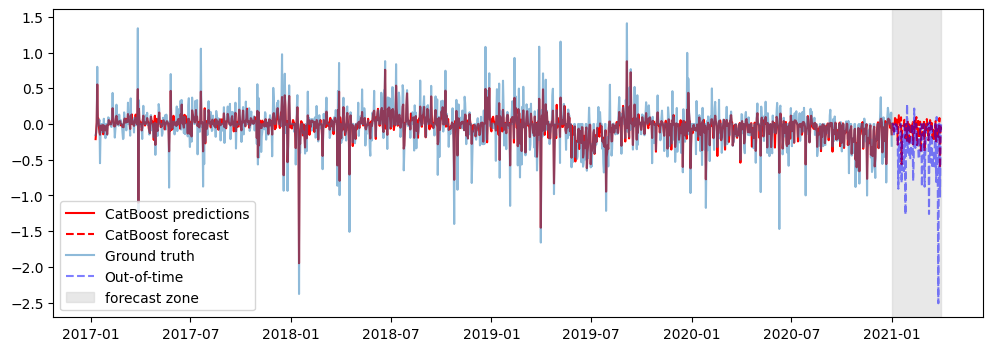

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(train_predictions, color='r', label='CatBoost predictions')
plt.plot(test_predictions, color='r', linestyle='--', label='CatBoost forecast')
plt.plot(y_train, label='Ground truth', alpha=0.5)
plt.plot(y_test, color='b', label='Out-of-time', linestyle='--', alpha=0.5)
forecast_start = y_test.index[0]
forecast_end = y_test.index[-1]
plt.axvspan(forecast_start, forecast_end, alpha=0.5, color='lightgrey', label='forecast zone')
plt.legend();

In [38]:
catboost_model.save_model('../data/artifacts/catboost_regressor.cbm')
X_train_opt.to_csv('../data/train.csv')
X_test_opt.to_csv('../data/test.csv')